# Location-dependent 2pcf estimation to find gradients

We have implemented a basis in the Continuous-Function Estimator that contains a dependence on the physical location of the pair. We can use this to see if there any cosmological-scale gradients hiding in our data. We test out this functionality in this notebook.

## Imports

In [10]:
import numpy as np
import scipy
from scipy.interpolate import BSpline
from scipy.interpolate import _bspl

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 200
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize': 'medium',
         'xtick.labelsize': 'medium',
         'ytick.labelsize': 'medium',
         'figure.autolayout': True,
         'figure.figsize': (4,3),
         'text.usetex': True,
         'text.latex.preamble': [r"\usepackage{bm}"]}
pylab.rcParams.update(params)

%load_ext autoreload
%autoreload 2
from colors_labels import *
import bao_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import Corrfunc
from Corrfunc.io import read_fortran_catalog
from Corrfunc.theory.DDsmu import DDsmu
from Corrfunc.utils import compute_amps
from Corrfunc.utils import evaluate_xi

## Loading and setup

Load in a test catalog:

In [4]:
realization = 1
boxsize = 750
nbar = '2e-4'
#nbar = '5e-5'
cat_tag = f'_L{boxsize}_n{nbar}_z057_patchy'
cat_fn = f'../catalogs/lognormal/cat{cat_tag}_lognormal_rlz{realization}.bin'

In [5]:
boxsize = 750.0
x, y, z = read_fortran_catalog(cat_fn)
nd = len(x)
print("Number of data points:",nd)

Number of data points: 85575


Generate a random catalog:

In [6]:
randmult = 2
nr = nd*randmult
xr = np.random.rand(nr)*float(boxsize)
yr = np.random.rand(nr)*float(boxsize)
zr = np.random.rand(nr)*float(boxsize)
print("Number of data points:", nr)

Number of data points: 171150


Set the paramters that will apply to all of the computation:

In [7]:
rmin = 40.0
rmax = 140.0
ntopbins = 10
r_edges = np.linspace(rmin, rmax, ntopbins+1)

ncont = 2000
r_fine = np.linspace(rmin, rmax, ncont)

nmubins = 1
mumax = 1.0
periodic = False #assume non-periodic for gradient finding!
nthreads = 1
verbose = False

## Tophat estimation

We first perform the standard tophat estimation.

In [7]:
proj_type = 'tophat'
projfn = None
nprojbins = ntopbins

In [8]:
_, dd_top, _ = DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z, 
                           proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, 
                           periodic=periodic, boxsize=boxsize, verbose=verbose)

In [9]:
_, dr_top, _ = DDsmu(0, nthreads, r_edges, mumax, nmubins, x, y, z, 
                           X2=xr, Y2=yr, Z2=zr, 
                           proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, 
                           periodic=periodic, boxsize=boxsize, verbose=verbose)

In [10]:
_, rr_top, qq_top = DDsmu(1, nthreads, r_edges, mumax, nmubins, xr, yr, zr, 
                                 proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, 
                                 periodic=periodic, boxsize=boxsize, verbose=verbose)

In [11]:
amps_top = compute_amps(nprojbins, nd, nd, nr, nr, dd_top, dr_top, dr_top, rr_top, qq_top)

In [12]:
xi_top = evaluate_xi(amps_top, r_fine, proj_type, rbins=r_edges)

## Tophat basis with xyz dependence ("gradient")

Now we include a gradient. The syntax is very similar; we just need to define the weight_type, so we can pass the xyz locations.

In [13]:
proj_type = 'gradient'
weight_type = 'pair_product_gradient'
projfn = None
nprojbins = ntopbins*4

We need weights for the gradient function. The code expects an array of shape (n_weights, n_data). The first weight is the general weight for the galaxy, e.g. for systematics correction; for now we take it to be 1 for all galaxies, as these are theory boxes. The second weight is the x position of the galaxies, and the third and fourth the y and z positions respectively. 

In [14]:
weights = np.array([np.ones(nd), x, y, z])
weights_r = np.array([np.ones(nr), xr, yr, zr])

In [15]:
_, dd_proj, _ = DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z, weights1=weights, 
                           proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, 
                           periodic=periodic, boxsize=boxsize, verbose=verbose, weight_type=weight_type)

In [16]:
_, dr_proj, _ = DDsmu(0, nthreads, r_edges, mumax, nmubins, x, y, z, weights1=weights, 
                           X2=xr, Y2=yr, Z2=zr, weights2=weights_r, 
                           proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, 
                           periodic=periodic, boxsize=boxsize, verbose=verbose, weight_type=weight_type)

In [17]:
_, rr_proj, qq_proj = DDsmu(1, nthreads, r_edges, mumax, nmubins, xr, yr, zr, weights1=weights_r, 
                                 proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, 
                                 periodic=periodic, boxsize=boxsize, verbose=verbose, weight_type=weight_type)

In [18]:
amps_proj = compute_amps(nprojbins, nd, nd, nr, nr, dd_proj, dr_proj, dr_proj, rr_proj, qq_proj)


Now that we have the amplitudes, we can evaluate the 2pcf at any location - essentially the position of any imaginary galaxy pair. We fix the y and z locations to be the center of the box, and vary the x location across the box.

Text(0, 0.5, '$\\xi(r)$')

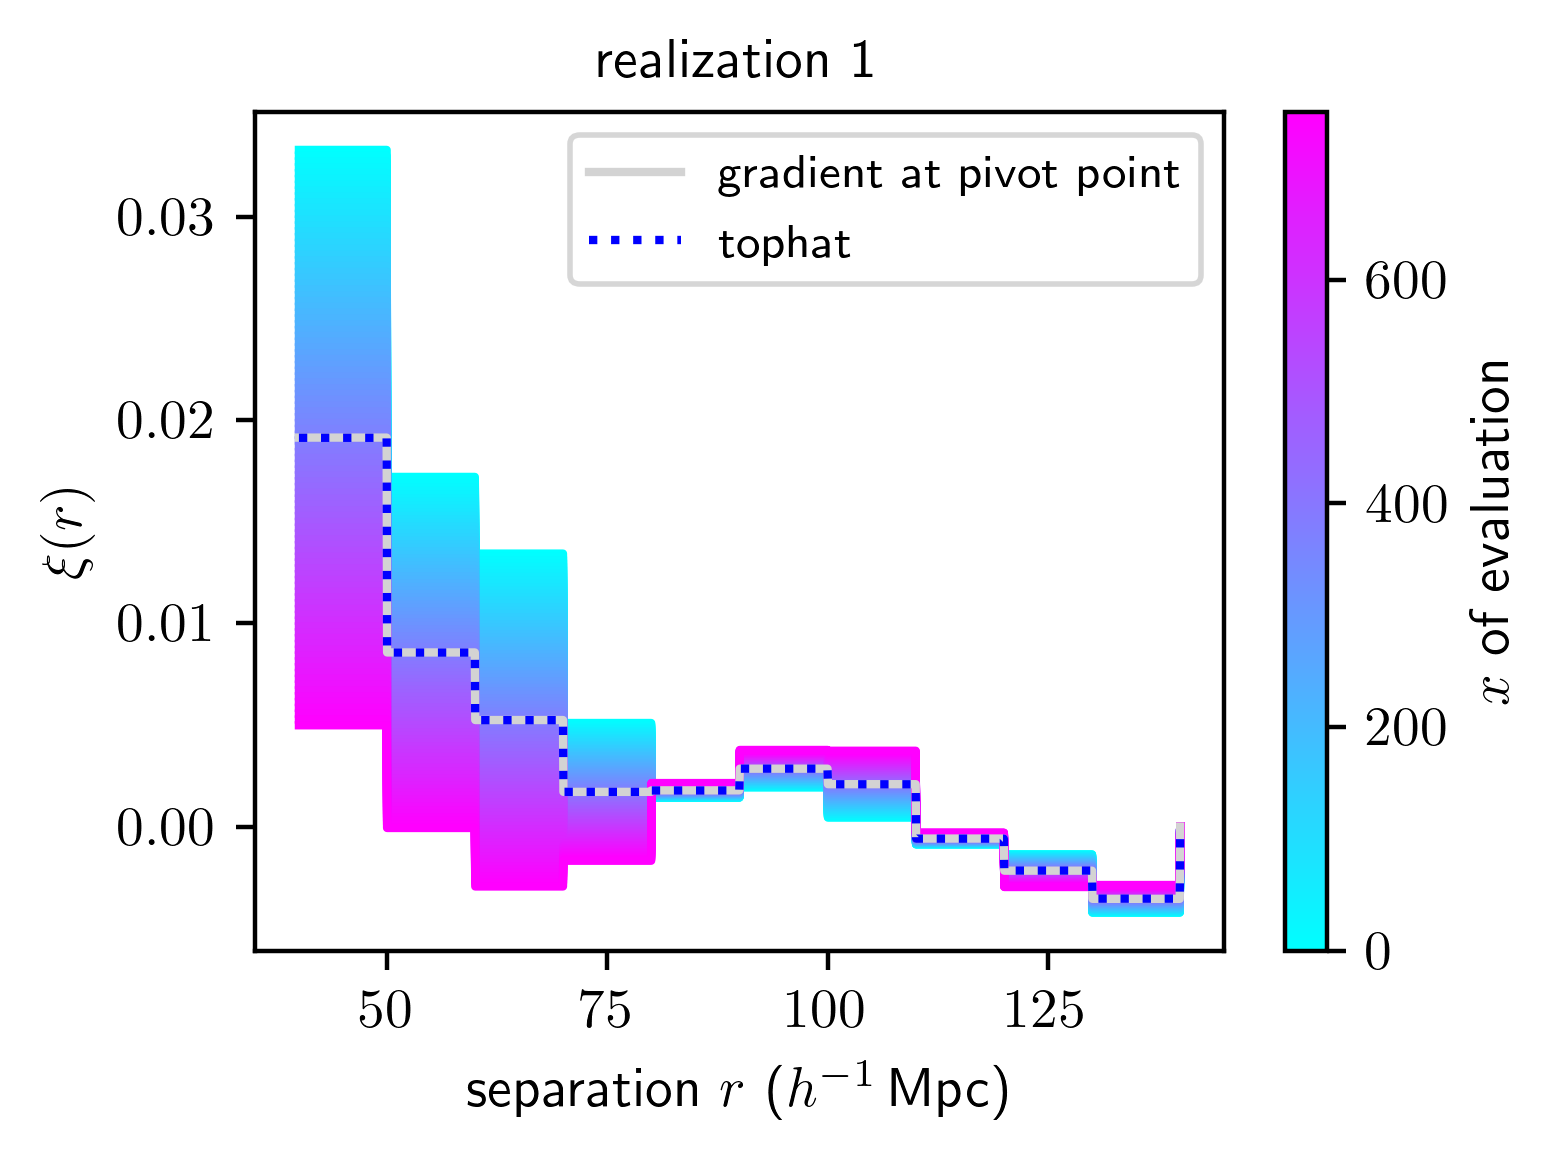

In [25]:
fig = plt.figure()
ax = plt.gca()

nlocs = 100
loc_min = 0.0
loc_max = 750.0
locs = np.linspace(loc_min, loc_max, nlocs)
locs_norm = matplotlib.colors.Normalize(vmin=loc_min, vmax=loc_max)
cmap = matplotlib.cm.get_cmap('cool')

for i, loc in enumerate(locs):
    weights1 = np.array([1.0, loc, 375.0, 375.0])
    weights2 = np.array([1.0, loc, 375.0, 375.0])
    xi_loc = evaluate_xi(amps_proj, r_fine, proj_type, rbins=r_edges, projfn=projfn, 
                     weights1=weights1, weights2=weights2, weight_type=weight_type)    
    plt.plot(r_fine, xi_loc, color=cmap(locs_norm(loc)))

weights1 = np.array([1.0, 375.0, 375.0, 375.0])
weights2 = np.array([1.0, 375.0, 375.0, 375.0])
xi_375 = evaluate_xi(amps_proj, r_fine, proj_type, rbins=r_edges, projfn=projfn, 
                 weights1=weights1, weights2=weights2, weight_type=weight_type)    
plt.plot(r_fine, xi_375, color='lightgrey', label='gradient at pivot point')
        
plt.plot(r_fine, xi_top, label='tophat', ls=':', color='blue')
plt.legend(loc='upper right')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, label=r'$x$ of evaluation')

plt.title("realization 1")
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi(r)$')

We can see that the location-dependent 2pcf evaluated at the pivot point is exactly the same as the regular tophat basis, as it must be.

## Interpretation of gradient results

The magnitude of each bin is the magnitude of the amplitude value associated with $x$ for that bin, where $x$ is the mean location of the galaxy pair. The direction of the $x$-dependence is the sign of the associated amplitude. 

The $x$-dependent amplitudes are the relative strength of clustering at that $x$ value. Galaxy pairs with larger $x$ locations will contribute a larger amount to that amplitude, while if they have an $x$ location near the pivot point, they will only contribute a small amount. The same goes for small $x$ locations. Thus if there were no gradient in the $x$ direction, we would expect small amplitudes that tell us there aren't disproportionately more large- or small-$x$ galaxies at a given separation scale.

This looks different for each mock realization! So we are seeing noise. We need to take some means to understand what's going on.

## Results on many realizations

We computed this gradient on many mocks. Let's see what's going on with a single one, as a check:

No handles with labels found to put in legend.


Text(0, 0.5, '$\\xi(r)$')

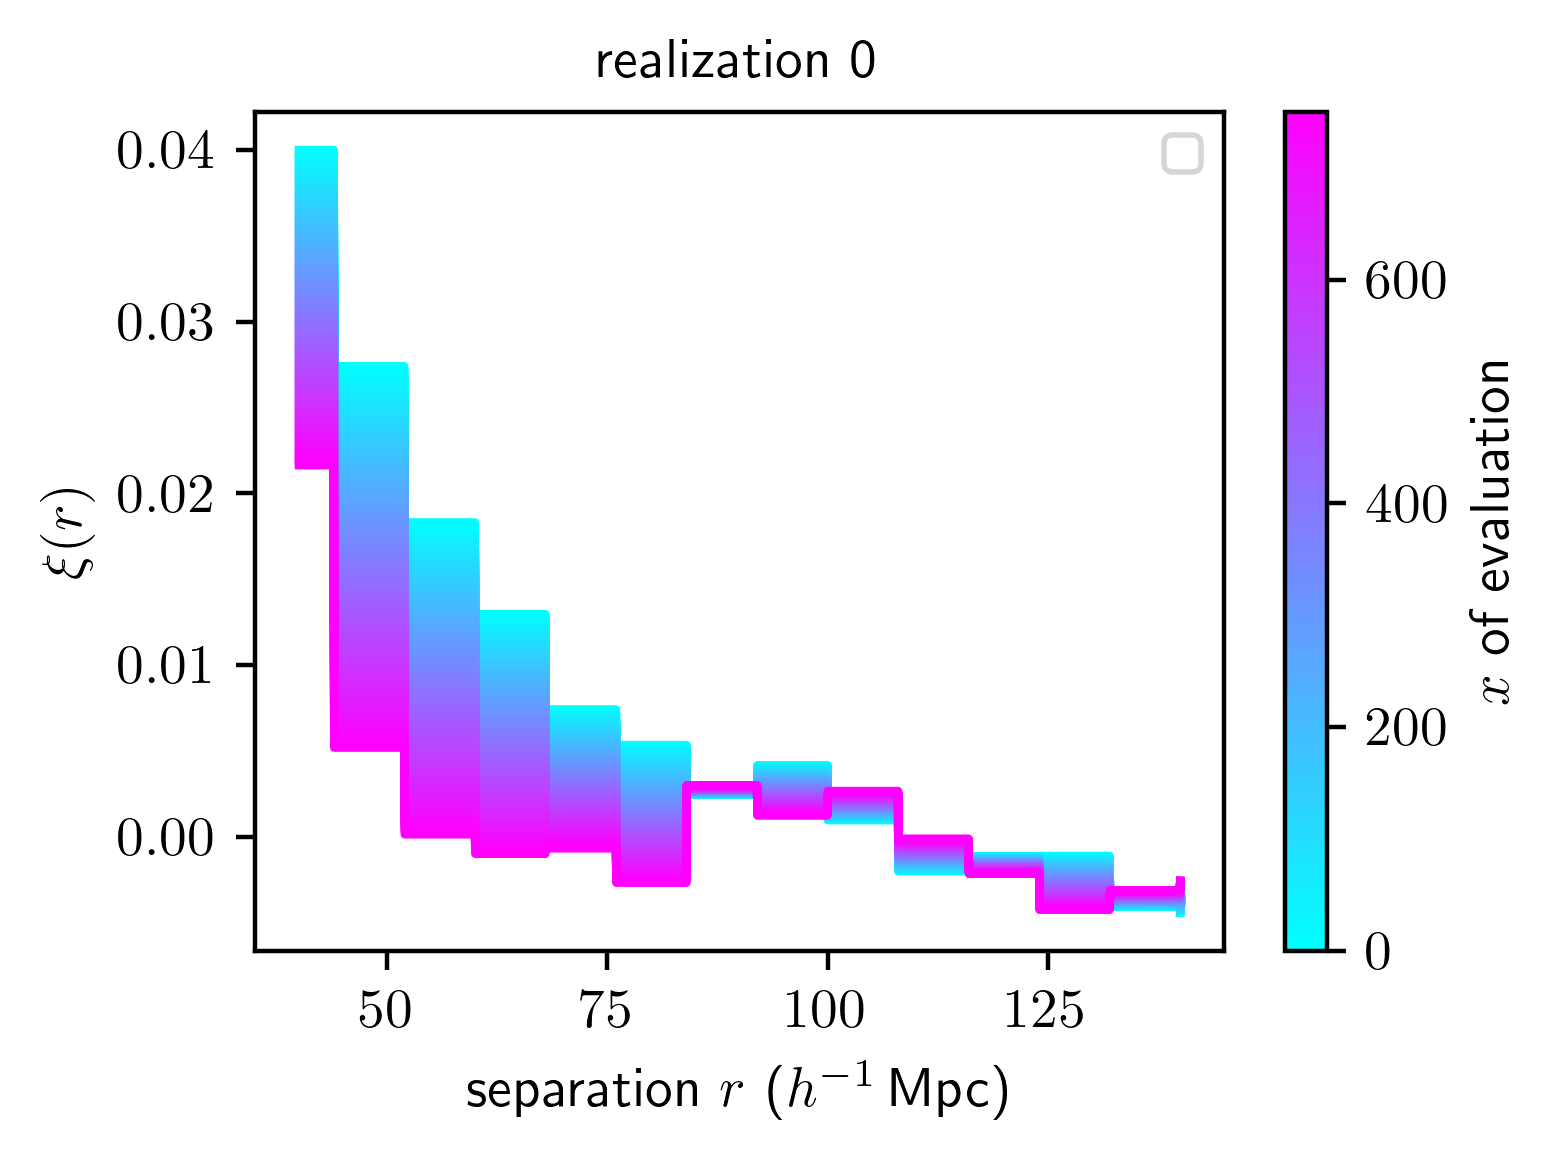

In [26]:
proj = 'gradient'
binwidth = 8
cf_tag = f"_{proj}_top_bw{binwidth}_nonperiodic"
Nr = 1

qq_tag = '_qqnum'
cat_tag = '_L750_n2e-4_z057_patchy'
result_dir = f'../results/results_lognormal{cat_tag}'
results_fn = f'{result_dir}/cf{cf_tag}{qq_tag}{cat_tag}_rlz{Nr}.npy'
r, xi, amps, proj, extra_dict = np.load(results_fn, allow_pickle=True)
r_edges_mocks = extra_dict['r_edges']

fig = plt.figure()
ax = plt.gca()

nlocs = 100
loc_min = 0.0
loc_max = 750.0
locs = np.linspace(loc_min, loc_max, nlocs)
locs_norm = matplotlib.colors.Normalize(vmin=loc_min, vmax=loc_max)
cmap = matplotlib.cm.get_cmap('cool')

for i, loc in enumerate(locs):
    weights1 = np.array([1.0, loc, 375.0, 375.0])
    weights2 = np.array([1.0, loc, 375.0, 375.0])
    xi_loc = evaluate_xi(amps, r_fine, proj_type, rbins=r_edges_mocks, projfn=projfn, 
                     weights1=weights1, weights2=weights2, weight_type=weight_type)    

    p = plt.plot(r_fine, xi_loc, color=cmap(locs_norm(loc)))

plt.legend(loc='upper right')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, label=r'$x$ of evaluation')

plt.title("realization 0")
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi(r)$')

Great, it's working. Now let's loop over a bunch, and evaluate at the center and the two extremes, and show the means:

[  0. 375. 750.]


Text(0, 0.5, '$\\xi(r)$')

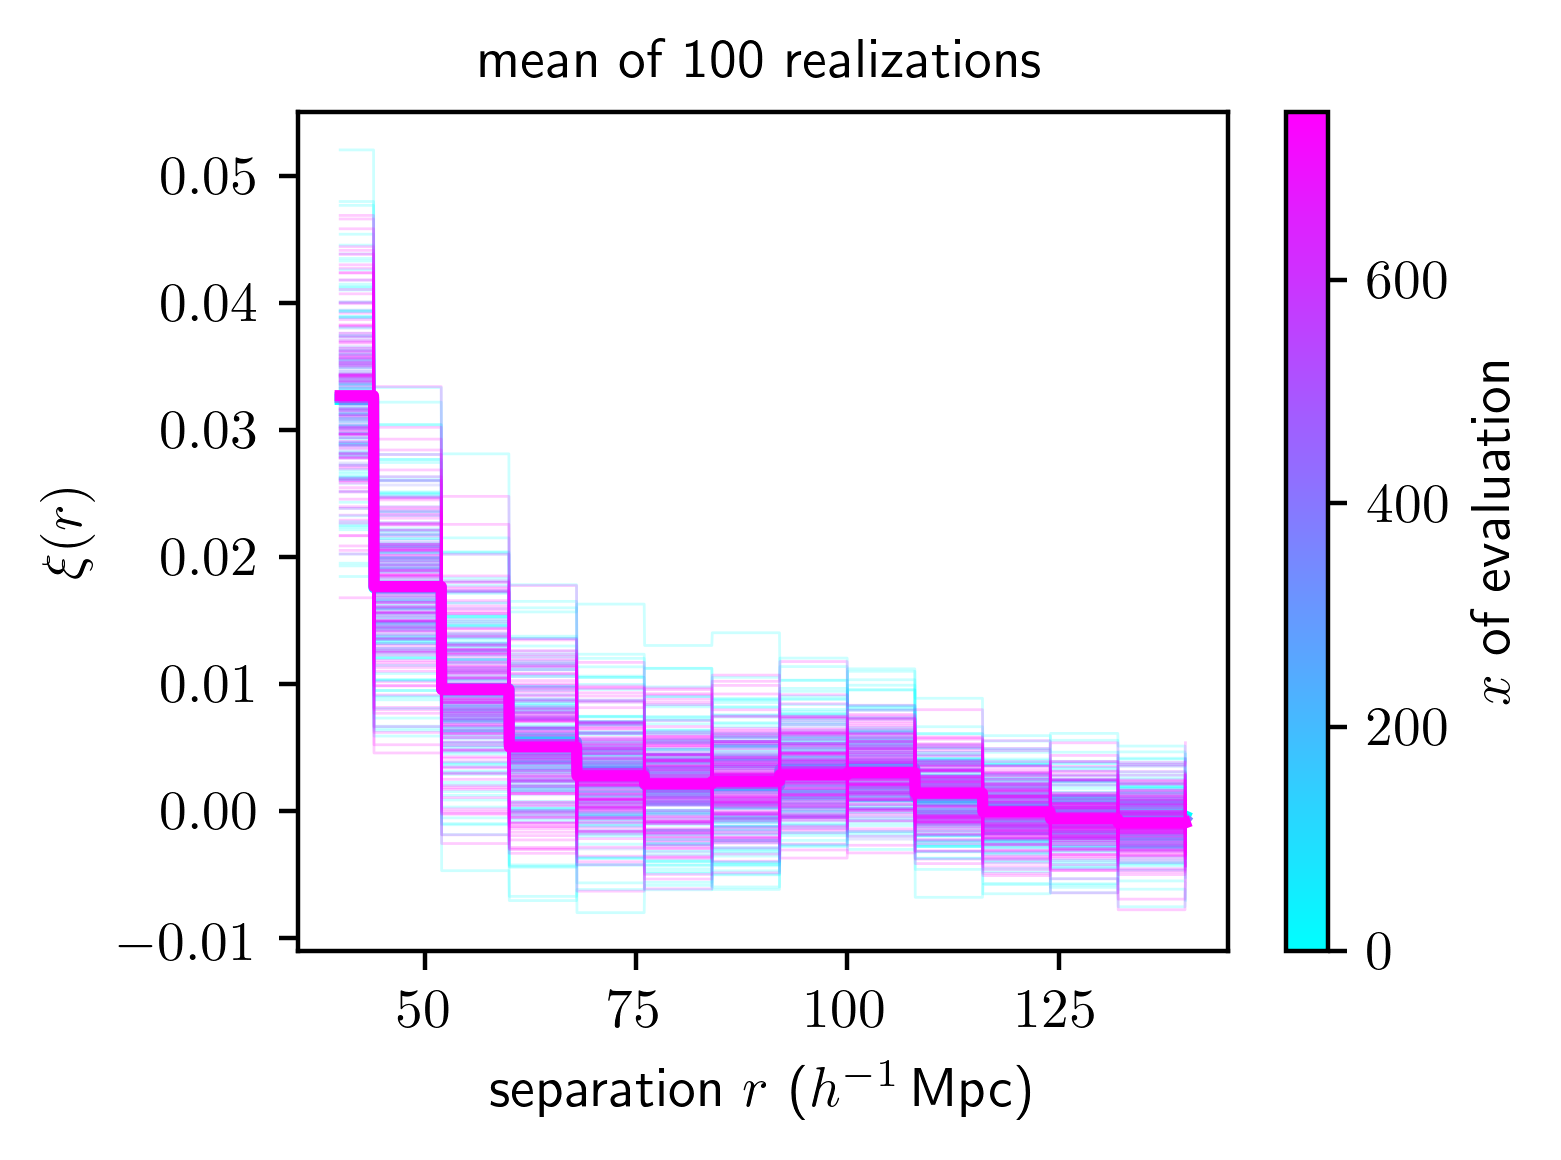

In [27]:
proj_type = 'gradient'
binwidth = 8
cf_tag = f"_{proj}_top_bw{binwidth}_nonperiodic"
realizations = range(100)
projfn = None
weight_type = 'pair_product_gradient'

qq_tag = '_qqnum'
cat_tag = '_L750_n2e-4_z057_patchy'
result_dir = f'../results/results_lognormal{cat_tag}'

nlocs = 3
loc_min = 0.0
loc_max = 750.0
locs = np.linspace(loc_min, loc_max, nlocs)
print(locs)

#locs = [375.]
locs_norm = matplotlib.colors.Normalize(vmin=loc_min, vmax=loc_max)
cmap = matplotlib.cm.get_cmap('cool')

fig = plt.figure()
ax = plt.gca()

for i, loc in enumerate(locs):
    weights1 = np.array([1.0, loc, 375.0, 375.0])
    weights2 = np.array([1.0, loc, 375.0, 375.0])
    
    xis = []
    
    for Nr in realizations:
        results_fn = f'{result_dir}/cf{cf_tag}{qq_tag}{cat_tag}_rlz{Nr}.npy'
        r, xi, amps, proj, extra_dict = np.load(results_fn, allow_pickle=True)
        r_edges_mocks = extra_dict['r_edges']

        xi_loc = evaluate_xi(amps, r_fine, proj_type, rbins=r_edges_mocks, projfn=projfn, 
                         weights1=weights1, weights2=weights2, weight_type=weight_type)    
        xis.append(xi_loc)
        plt.plot(r_fine, xi_loc, color=cmap(locs_norm(loc)), alpha=0.2, lw=0.5)

    xi_mean = np.mean(xis, axis=0)
    plt.plot(r_fine, xi_mean, color=cmap(locs_norm(loc)), alpha=1, lw=2)
    
#plt.legend(loc='upper right')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, label=r'$x$ of evaluation')
plt.title("mean of 100 realizations")
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi(r)$')

Now just the means, at lots of points in between:

Text(0, 0.5, '$\\xi(r)$')

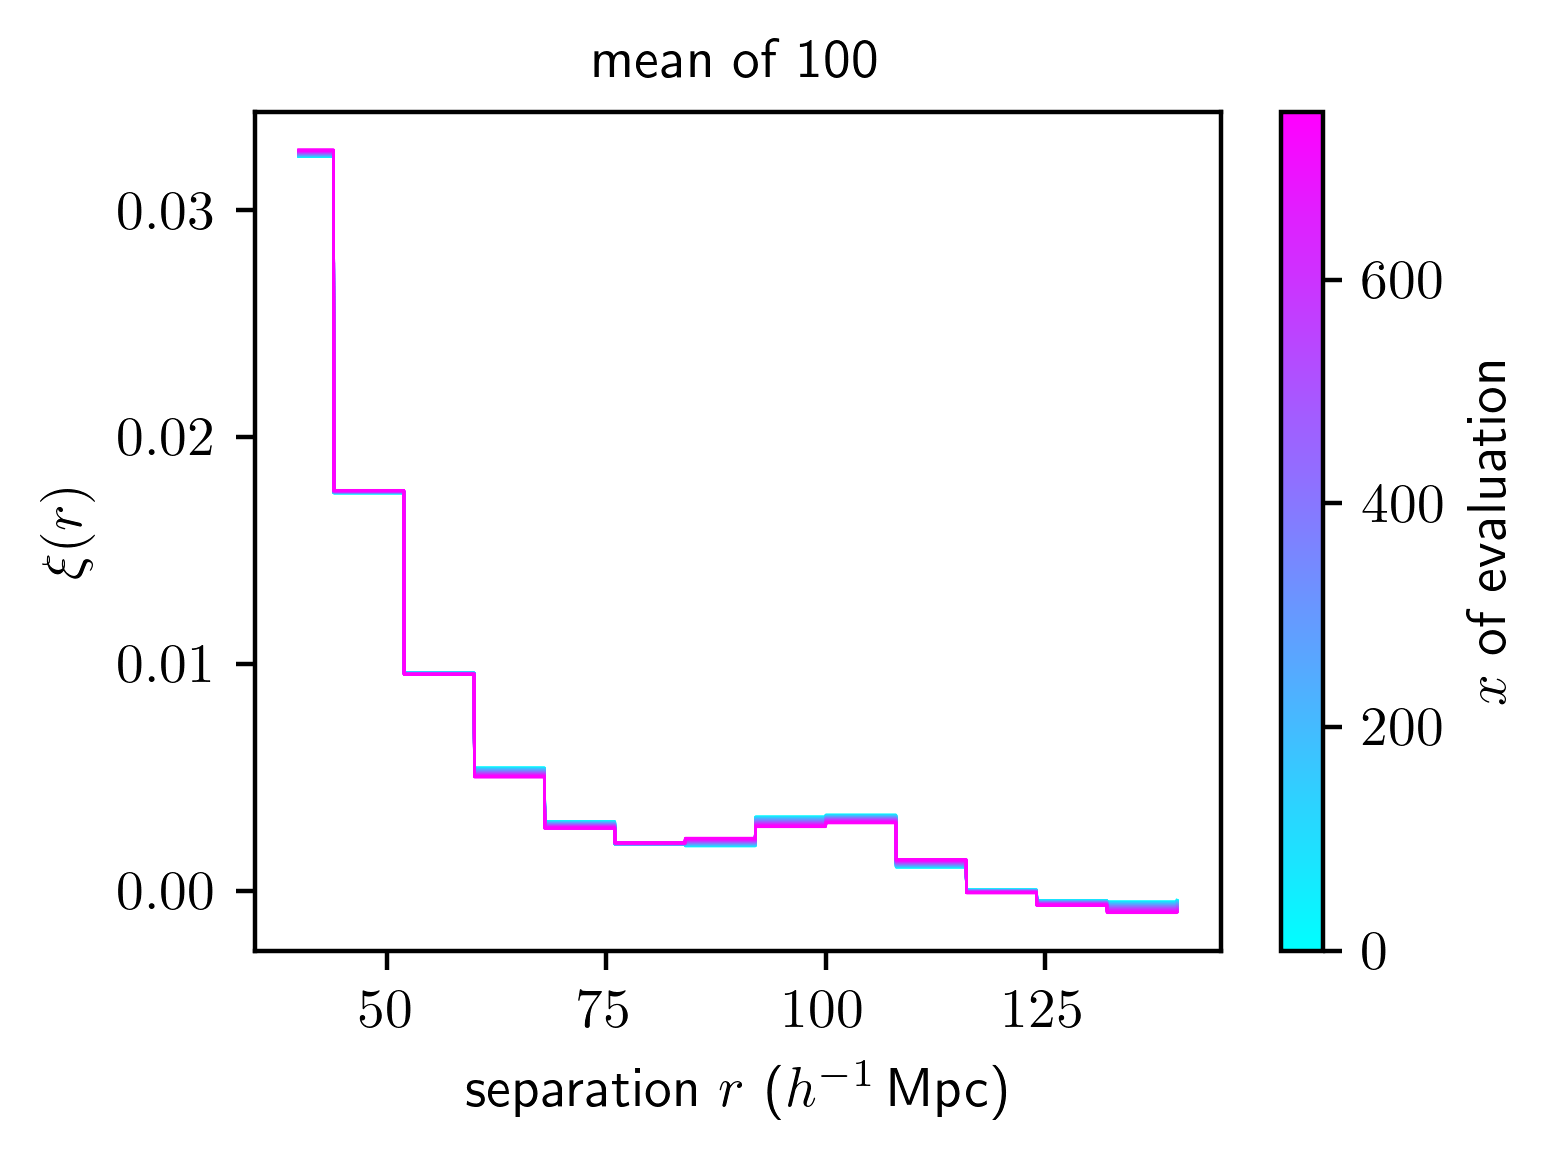

In [28]:
proj_type = 'gradient'
binwidth = 8
cf_tag = f"_{proj}_top_bw{binwidth}_nonperiodic"
realizations = range(100)
projfn = None
weight_type = 'pair_product_gradient'

qq_tag = '_qqnum'
cat_tag = '_L750_n2e-4_z057_patchy'
result_dir = f'../results/results_lognormal{cat_tag}'

nlocs = 50
loc_min = 0.0
loc_max = 750.0
locs = np.linspace(loc_min, loc_max, nlocs)

locs_norm = matplotlib.colors.Normalize(vmin=loc_min, vmax=loc_max)
cmap = matplotlib.cm.get_cmap('cool')

fig = plt.figure()
ax = plt.gca()

for i, loc in enumerate(locs):
    weights1 = np.array([1.0, loc, 375.0, 375.0])
    weights2 = np.array([1.0, loc, 375.0, 375.0])
    
    xis = []
    
    for Nr in realizations:
        results_fn = f'{result_dir}/cf{cf_tag}{qq_tag}{cat_tag}_rlz{Nr}.npy'
        r, xi, amps, proj, extra_dict = np.load(results_fn, allow_pickle=True)
        r_edges_mocks = extra_dict['r_edges']

        xi_loc = evaluate_xi(amps, r_fine, proj_type, rbins=r_edges_mocks, projfn=projfn, 
                         weights1=weights1, weights2=weights2, weight_type=weight_type)    
        xis.append(xi_loc)

    xi_mean = np.mean(xis, axis=0)
    plt.plot(r_fine, xi_mean, color=cmap(locs_norm(loc)), alpha=1, lw=0.5)
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, label=r'$x$ of evaluation')
plt.title("mean of 100")
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi(r)$')

Check that out, no dependence, as expected! Now can we find a gradient if there is one...?!?

Compare to lower number density:

Text(0, 0.5, '$\\xi(r)$')

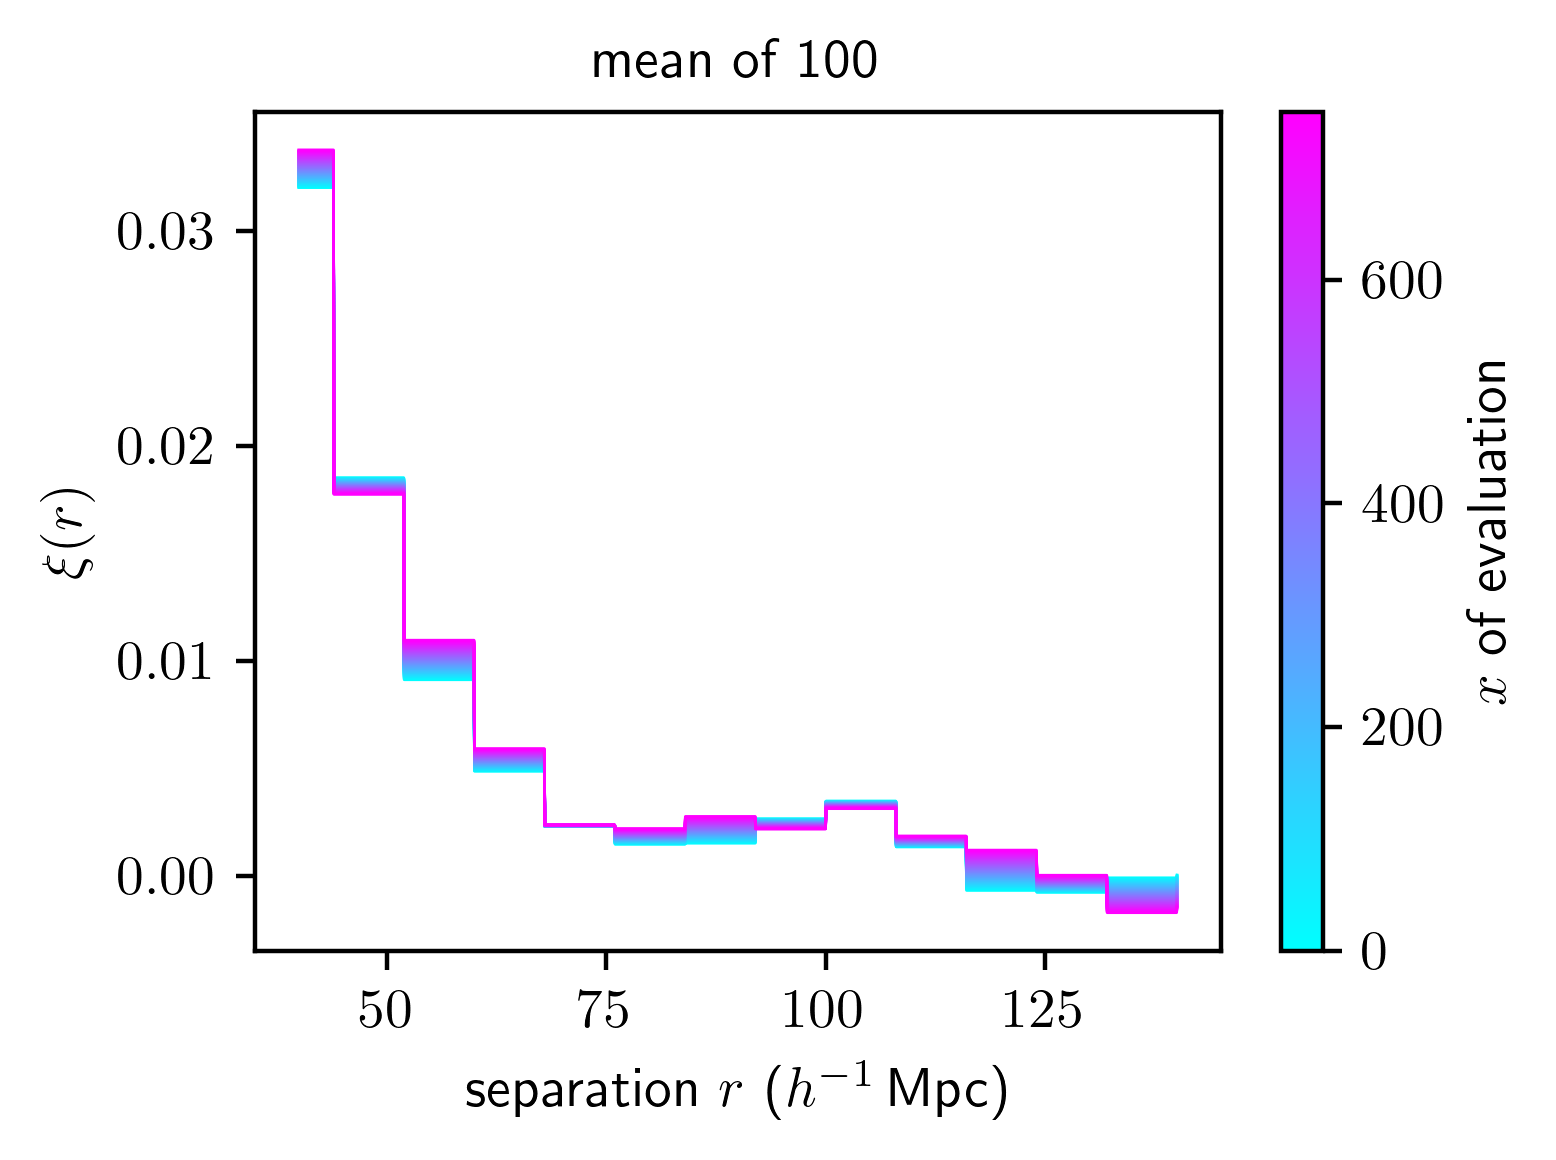

In [29]:
proj_type = 'gradient'
binwidth = 8
cf_tag = f"_{proj}_top_bw{binwidth}_nonperiodic"
realizations = range(100)
projfn = None
weight_type = 'pair_product_gradient'

qq_tag = '_qqnum'
cat_tag = '_L750_n5e-5_z057_patchy'
result_dir = f'../results/results_lognormal{cat_tag}'

nlocs = 50
loc_min = 0.0
loc_max = 750.0
locs = np.linspace(loc_min, loc_max, nlocs)

locs_norm = matplotlib.colors.Normalize(vmin=loc_min, vmax=loc_max)
cmap = matplotlib.cm.get_cmap('cool')

fig = plt.figure()
ax = plt.gca()

for i, loc in enumerate(locs):
    weights1 = np.array([1.0, loc, 375.0, 375.0])
    weights2 = np.array([1.0, loc, 375.0, 375.0])
    
    xis = []
    
    for Nr in realizations:
        results_fn = f'{result_dir}/cf{cf_tag}{qq_tag}{cat_tag}_rlz{Nr}.npy'
        r, xi, amps, proj, extra_dict = np.load(results_fn, allow_pickle=True)
        r_edges_mocks = extra_dict['r_edges']

        xi_loc = evaluate_xi(amps, r_fine, proj_type, rbins=r_edges_mocks, projfn=projfn, 
                         weights1=weights1, weights2=weights2, weight_type=weight_type)    
        xis.append(xi_loc)

    xi_mean = np.mean(xis, axis=0)
    plt.plot(r_fine, xi_mean, color=cmap(locs_norm(loc)), alpha=1, lw=0.5)
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, label=r'$x$ of evaluation')
plt.title("mean of 100")
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi(r)$')

# Exploring f_c

In [6]:
L = 1.
N = 10000
xs_clust = np.random.uniform(-L/2,L/2,(2,N))
# generate a random data set (same size as mock)
xs_uncl = np.random.uniform(-L/2,L/2,(2,N))
print(min(xs_clust[0]), max(xs_uncl[0]))
print(min(xs_clust[1]), max(xs_uncl[1]))

-0.4999628605396378 0.49996765327723747
-0.4996267713593574 0.49992619442765374


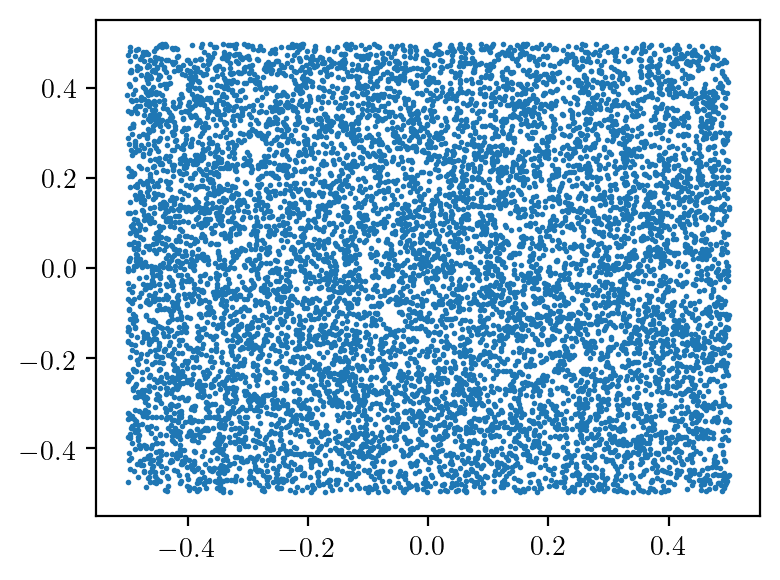

In [7]:
plt.scatter(xs_clust[0],xs_clust[1],s=1)

In [8]:
m = 1.0
b = 0.5

w_hat = np.array([0,1])

# for each catalog, make random uniform deviates
rs_clust = np.random.uniform(size=N)
rs_uncl = np.random.uniform(size=N)

# dot product onto the unit vectors
ws_clust = np.dot(w_hat,xs_clust)
ws_uncl = np.dot(w_hat,xs_uncl)

print(min(xs_clust[1]), max(xs_uncl[1]))
print(min(ws_clust), max(ws_uncl))

ts_clust =  m * ws_clust + b
ts_uncl = m * ws_uncl + b
# square thresholds
print(min(ts_clust), max(ts_clust))
#print()
ts_clust *= ts_clust
ts_uncl *= ts_uncl 
# print(min(ts_clust), max(ts_clust))

# assert that ts range from 0 to 1
# assert np.all(ts_clust > 0)
# assert np.all(ts_clust < 1)

# desired indices
I_clust = rs_clust < ts_clust
I_uncl = rs_uncl > ts_uncl
# append
xs = np.append(xs_clust.T[I_clust], xs_uncl.T[I_uncl],axis=0)
print(len(xs_clust.T[I_clust]), len(xs_uncl.T[I_uncl]), len(xs))
print(len(xs_clust.T[I_clust])/len(xs))

-0.4996267713593574 0.49992619442765374
-0.4996267713593574 0.49992619442765374
0.00037322864064259775 0.9999459601704362
3256 6636 9892
0.3291548726243429


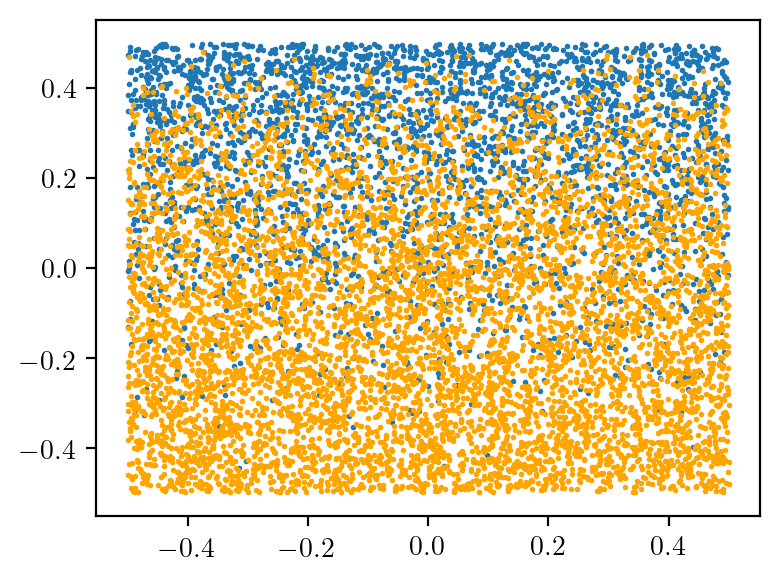

In [9]:
fig2 = plt.figure()

xs_clust_grad = xs_clust.T[I_clust]
xs_uncl_grad = xs_uncl.T[I_uncl]

xy_slice_clust = xs_clust_grad
xy_slice_uncl = xs_uncl_grad

plt.scatter(xy_slice_clust[:,0],xy_slice_clust[:,1],s=1,c="C0",label="clustered")
plt.scatter(xy_slice_uncl[:,0],xy_slice_uncl[:,1],s=1,c="orange",label="unclustered")

In [10]:
xs_clust_grad[:,1]

array([-0.14921609,  0.47869441,  0.10392476, ...,  0.28000437,
        0.266933  ,  0.48486795])

In [11]:

ybins = np.linspace(-L/2,L/2,16)
yavg = 0.5*(ybins[1:]+ybins[:-1])
fracs = []
for i in range(len(ybins)-1):
    #print(ybins[i],ybins[i+1])
    nclust = len(np.where((ybins[i+1]>xs_clust_grad[:,1]) & (xs_clust_grad[:,1]>ybins[i]))[0])
    nunclust = len(np.where((ybins[i+1]>xs_uncl_grad[:,1]) & (xs_uncl_grad[:,1]>ybins[i]))[0])
    #print(f'{nclust/(nclust+nunclust):.3f}')
    fracs.append(nclust/(nclust+nunclust))

In [12]:
plt.plot(yavg, fracs)
plt.ylabel('f_c')

Text(0, 0.5, 'f_c')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f2602800a60> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'f_c'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/users/ksf293/.cache/matplotlib/tex.cache/6090c6d8d35fce15c4d178df3c21e44
b.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-04-06>
(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/latex/base/size10.clo)
)
(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/latex/type1cm/type1cm.
sty)
(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/latex/base/textcomp.st
y)
(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/latex/base/inputenc.st
y) (/home/users/ksf293/external/texlive/2020/texmf-dist/tex/latex/tools/bm.sty)

(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/latex/geometry/geometr
y.sty
(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/latex/graphics/keyval.
sty)
(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/generic/iftex/ifvtex.s
ty
(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/generic/iftex/iftex.st
y))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/latex/l3backend/l3back
end-dvips.def)
No file 6090c6d8d35fce15c4d178df3c21e44b.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 \fontsize{10.000000}{12.500000}{\sffamily f_
                                                 c}
No pages of output.
Transcript written on 6090c6d8d35fce15c4d178df3c21e44b.log.




RuntimeError: latex was not able to process the following string:
b'f_c'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/users/ksf293/.cache/matplotlib/tex.cache/6090c6d8d35fce15c4d178df3c21e44
b.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-04-06>
(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/latex/base/size10.clo)
)
(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/latex/type1cm/type1cm.
sty)
(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/latex/base/textcomp.st
y)
(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/latex/base/inputenc.st
y) (/home/users/ksf293/external/texlive/2020/texmf-dist/tex/latex/tools/bm.sty)

(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/latex/geometry/geometr
y.sty
(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/latex/graphics/keyval.
sty)
(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/generic/iftex/ifvtex.s
ty
(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/generic/iftex/iftex.st
y))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
(/home/users/ksf293/external/texlive/2020/texmf-dist/tex/latex/l3backend/l3back
end-dvips.def) (./6090c6d8d35fce15c4d178df3c21e44b.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 \fontsize{10.000000}{12.500000}{\sffamily f_
                                                 c}
No pages of output.
Transcript written on 6090c6d8d35fce15c4d178df3c21e44b.log.




<Figure size 400x300 with 1 Axes>

# Gradients with BAO-based basis

In [20]:
cf_tag_bao = "_baoiter_cosmob17_adaptive2"
projfn, nprojbins, bases_bao, amps = bao_utils.get_gradient_bao_params(cat_tag=cat_tag, cf_tag=cf_tag_bao, Nr=realization)
projfn

'../tables/bases_L750_n2e-4_z057_patchy_baoiter_cosmob17_adaptive2_rlz1.dat'

In [17]:
bases_grad = np.loadtxt(projfn)
bases_grad.shape

(1000, 2)

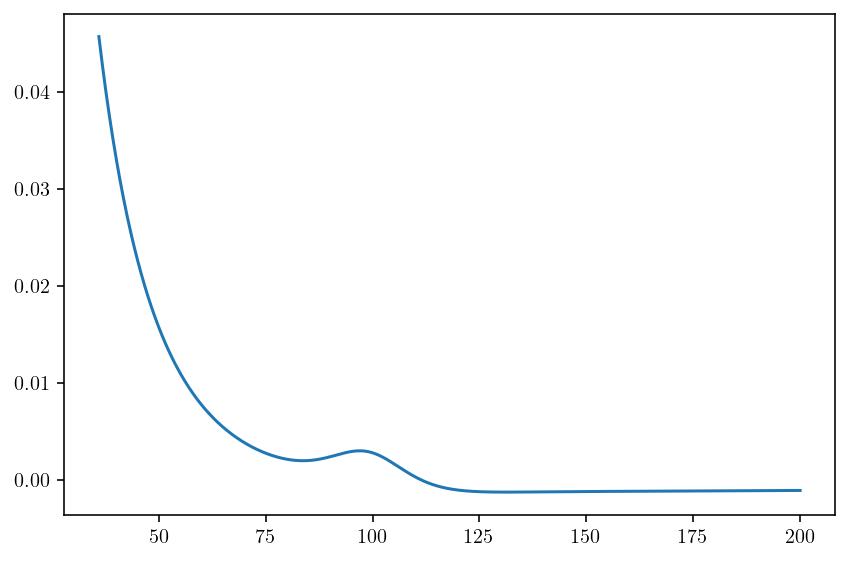

In [19]:
plt.plot(bases_grad[:,0], bases_grad[:,1])

(1000, 6)


(-0.005, 0.02)

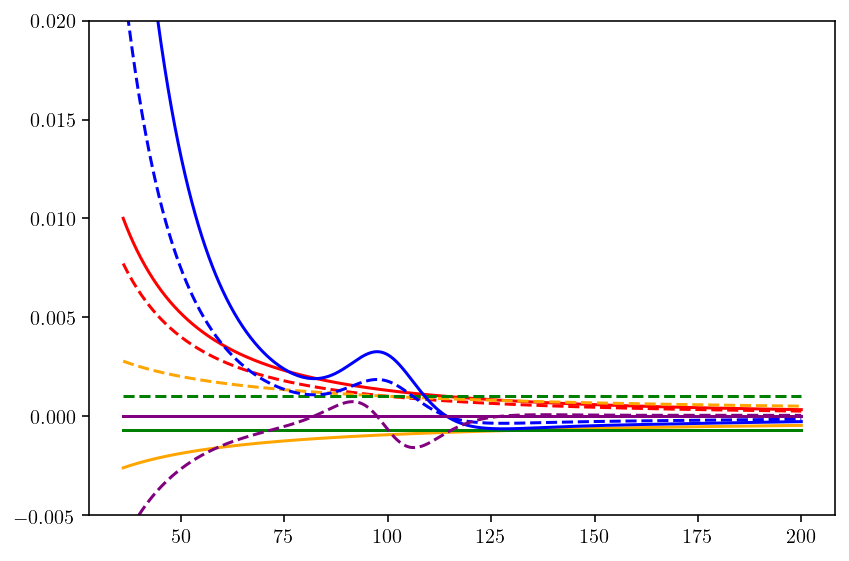

In [33]:
print(bases_bao.shape)
colors = ['red', 'orange', 'green', 'blue', 'purple']
for b in range(1,bases_bao.shape[1]):
    plt.plot(bases_bao[:,0], bases_bao[:,b], color=colors[b-1], ls='--')
    plt.plot(bases_bao[:,0], bases_bao[:,b]*amps[b-1], color=colors[b-1], ls='-')
    
plt.ylim(-0.005, 0.02)

[ 1.00248684e+00 -3.13261819e-04 -7.42097520e-04  4.24442644e-04]
[375.0, 375.0, 375.0]
[   1. -375.    0.    0.]


Text(0, 0.5, '$\\xi(r)$')

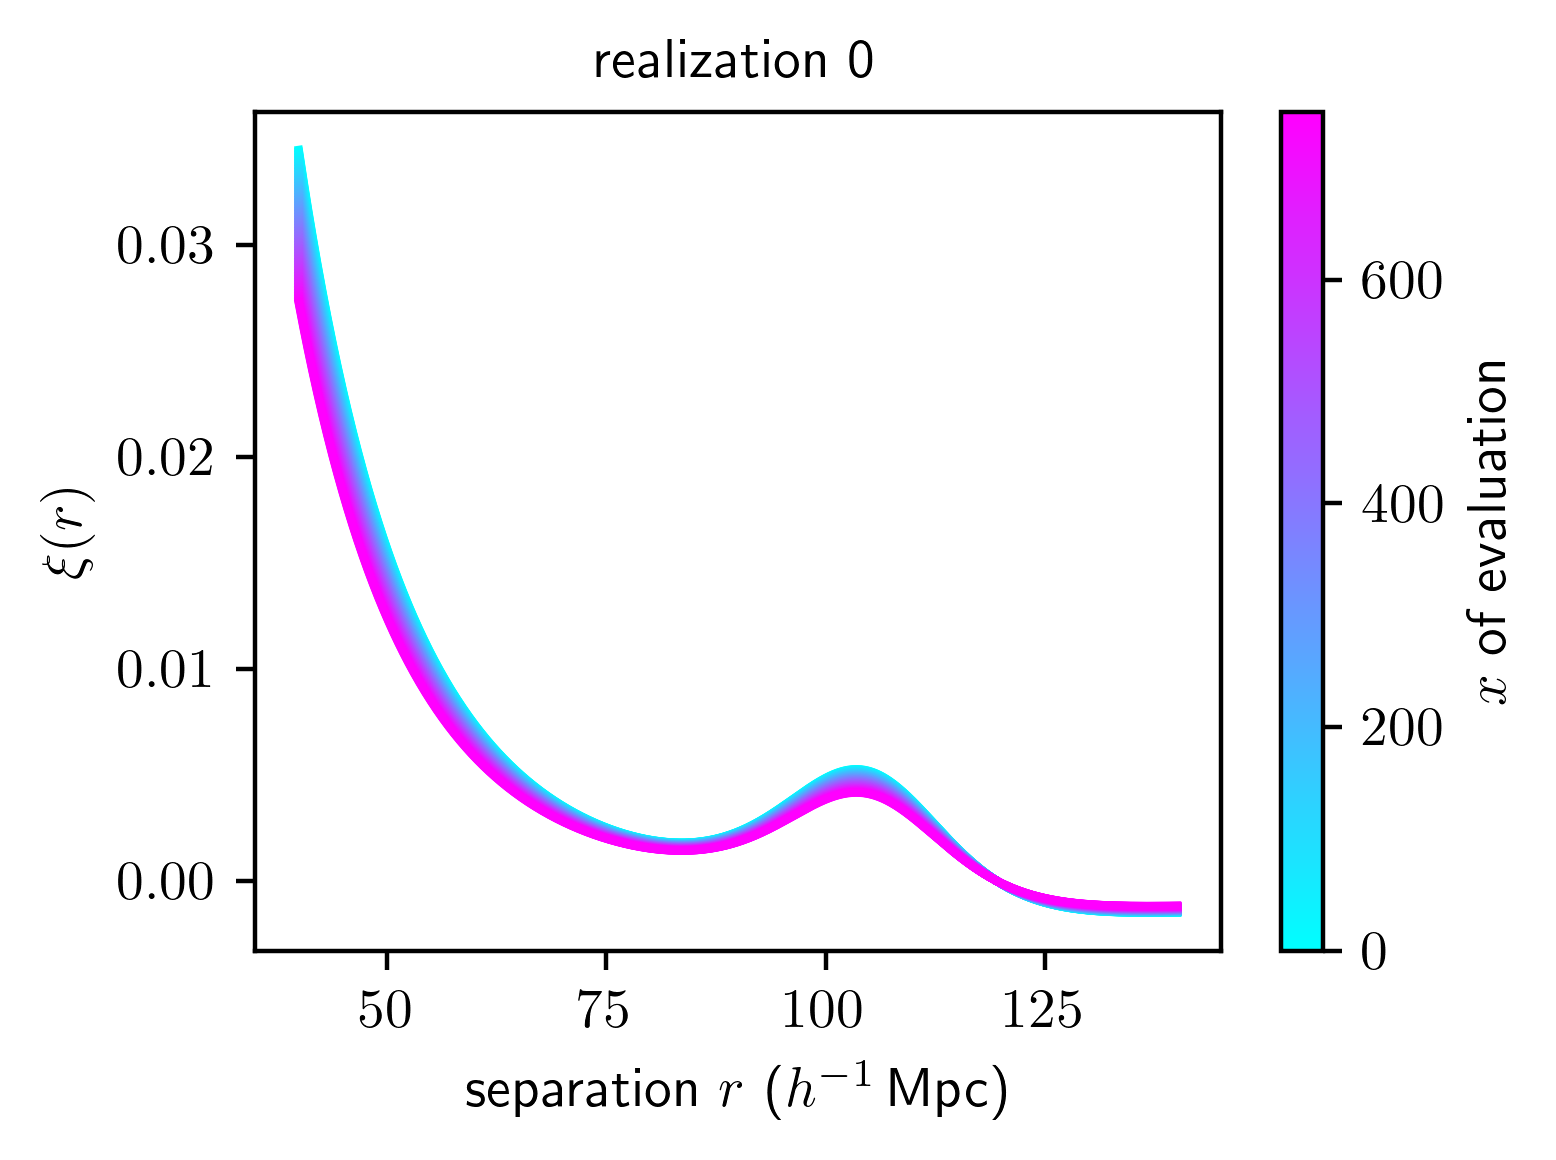

In [10]:
proj = 'gradient'
binwidth = 10 #dummy
cf_tag = f"_{proj}_bao_rand3x"
Nr = 0

L = 750
cat_tag = f'_L{L}_n5e-5_z057_patchy'
qq_tag = '_qqnum'

result_dir = f'../results/results_lognormal{cat_tag}'
results_fn = f'{result_dir}/cf{cf_tag}{qq_tag}{cat_tag}_rlz{Nr}.npy'
r, xi, amps, proj, extra_dict = np.load(results_fn, allow_pickle=True)
print(amps)
r_edges_mocks = extra_dict['r_edges']
proj_type, projfn, weight_type, loc_pivot = \
           extra_dict['proj_type'],  extra_dict['projfn'], extra_dict['weight_type'], extra_dict['loc_pivot']

print(loc_pivot)
fig = plt.figure()
ax = plt.gca()

nlocs = 100
loc_min = 0
loc_max = L
locs = np.linspace(loc_min, loc_max, nlocs)
locs_norm = matplotlib.colors.Normalize(vmin=loc_min, vmax=loc_max)
cmap = matplotlib.cm.get_cmap('cool')

for i, loc in enumerate(locs):
    weights1 = np.array([1.0, loc-loc_pivot[0], L/2.-loc_pivot[1], L/2.-loc_pivot[2]])
    weights2 = weights1 #because we just take the average of these and want to get this back
    xi_loc = evaluate_xi(amps, r_fine, proj_type, rbins=r_edges_mocks, projfn=projfn, 
                     weights1=weights1, weights2=weights2, weight_type=weight_type)    

    p = plt.plot(r_fine, xi_loc, color=cmap(locs_norm(loc)))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, label=r'$x$ of evaluation')

plt.title("realization 0")
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi(r)$')

[ 1.02899859e+00 -1.18013602e-03 -4.00919107e-05  1.29068834e-03]
[375.0, 375.0, 375.0]
[   1. -375.    0.    0.]


Text(0, 0.5, '$\\xi(r)$')

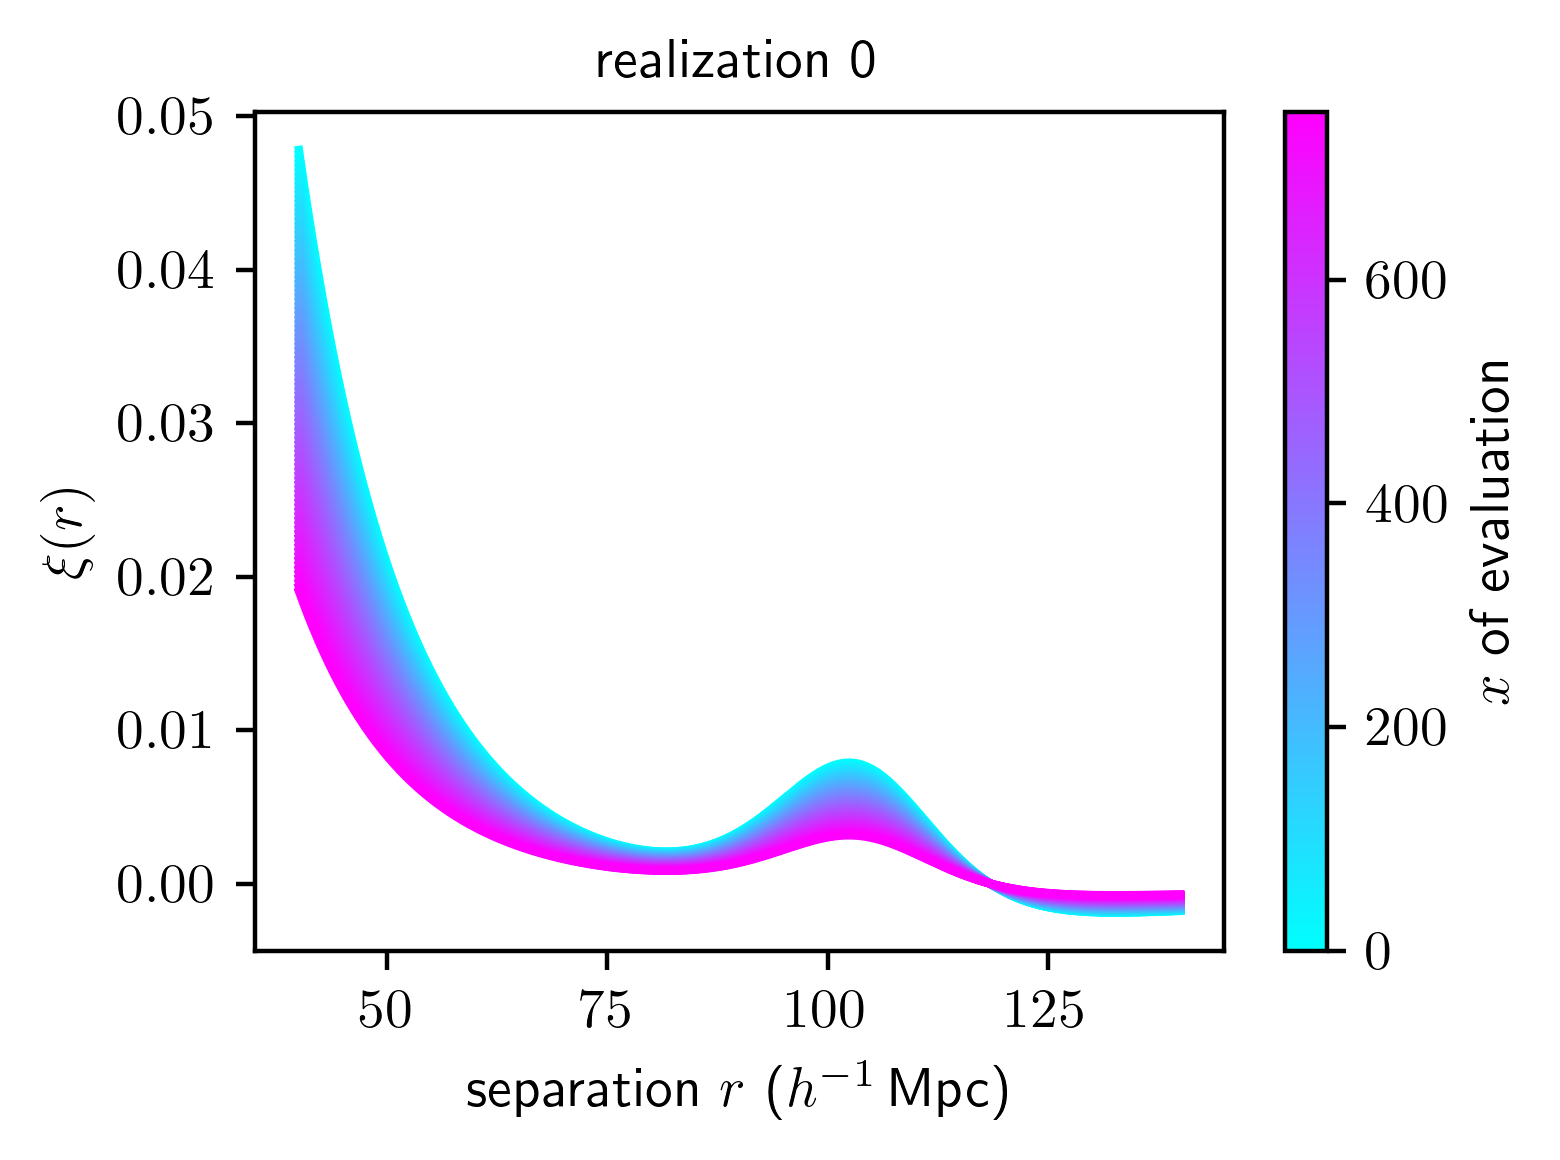

In [11]:
proj = 'gradient'
binwidth = 10 #dummy
cf_tag = f"_{proj}_bao_rand3x"
Nr = 0

L = 750
cat_tag = f'_L{L}_n2e-4_z057_patchy'
qq_tag = '_qqnum'

result_dir = f'../results/results_lognormal{cat_tag}'
results_fn = f'{result_dir}/cf{cf_tag}{qq_tag}{cat_tag}_rlz{Nr}.npy'
r, xi, amps, proj, extra_dict = np.load(results_fn, allow_pickle=True)
print(amps)
r_edges_mocks = extra_dict['r_edges']
proj_type, projfn, weight_type, loc_pivot = \
           extra_dict['proj_type'],  extra_dict['projfn'], extra_dict['weight_type'], extra_dict['loc_pivot']

print(loc_pivot)
fig = plt.figure()
ax = plt.gca()

nlocs = 100
loc_min = 0
loc_max = L
locs = np.linspace(loc_min, loc_max, nlocs)
locs_norm = matplotlib.colors.Normalize(vmin=loc_min, vmax=loc_max)
cmap = matplotlib.cm.get_cmap('cool')

for i, loc in enumerate(locs):
    weights1 = np.array([1.0, loc-loc_pivot[0], L/2.-loc_pivot[1], L/2.-loc_pivot[2]])
    weights2 = weights1 #because we just take the average of these and want to get this back
    xi_loc = evaluate_xi(amps, r_fine, proj_type, rbins=r_edges_mocks, projfn=projfn, 
                     weights1=weights1, weights2=weights2, weight_type=weight_type)    

    p = plt.plot(r_fine, xi_loc, color=cmap(locs_norm(loc)))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, label=r'$x$ of evaluation')

plt.title("realization 0")
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi(r)$')

Text(0, 0.5, '$\\xi(r)$')

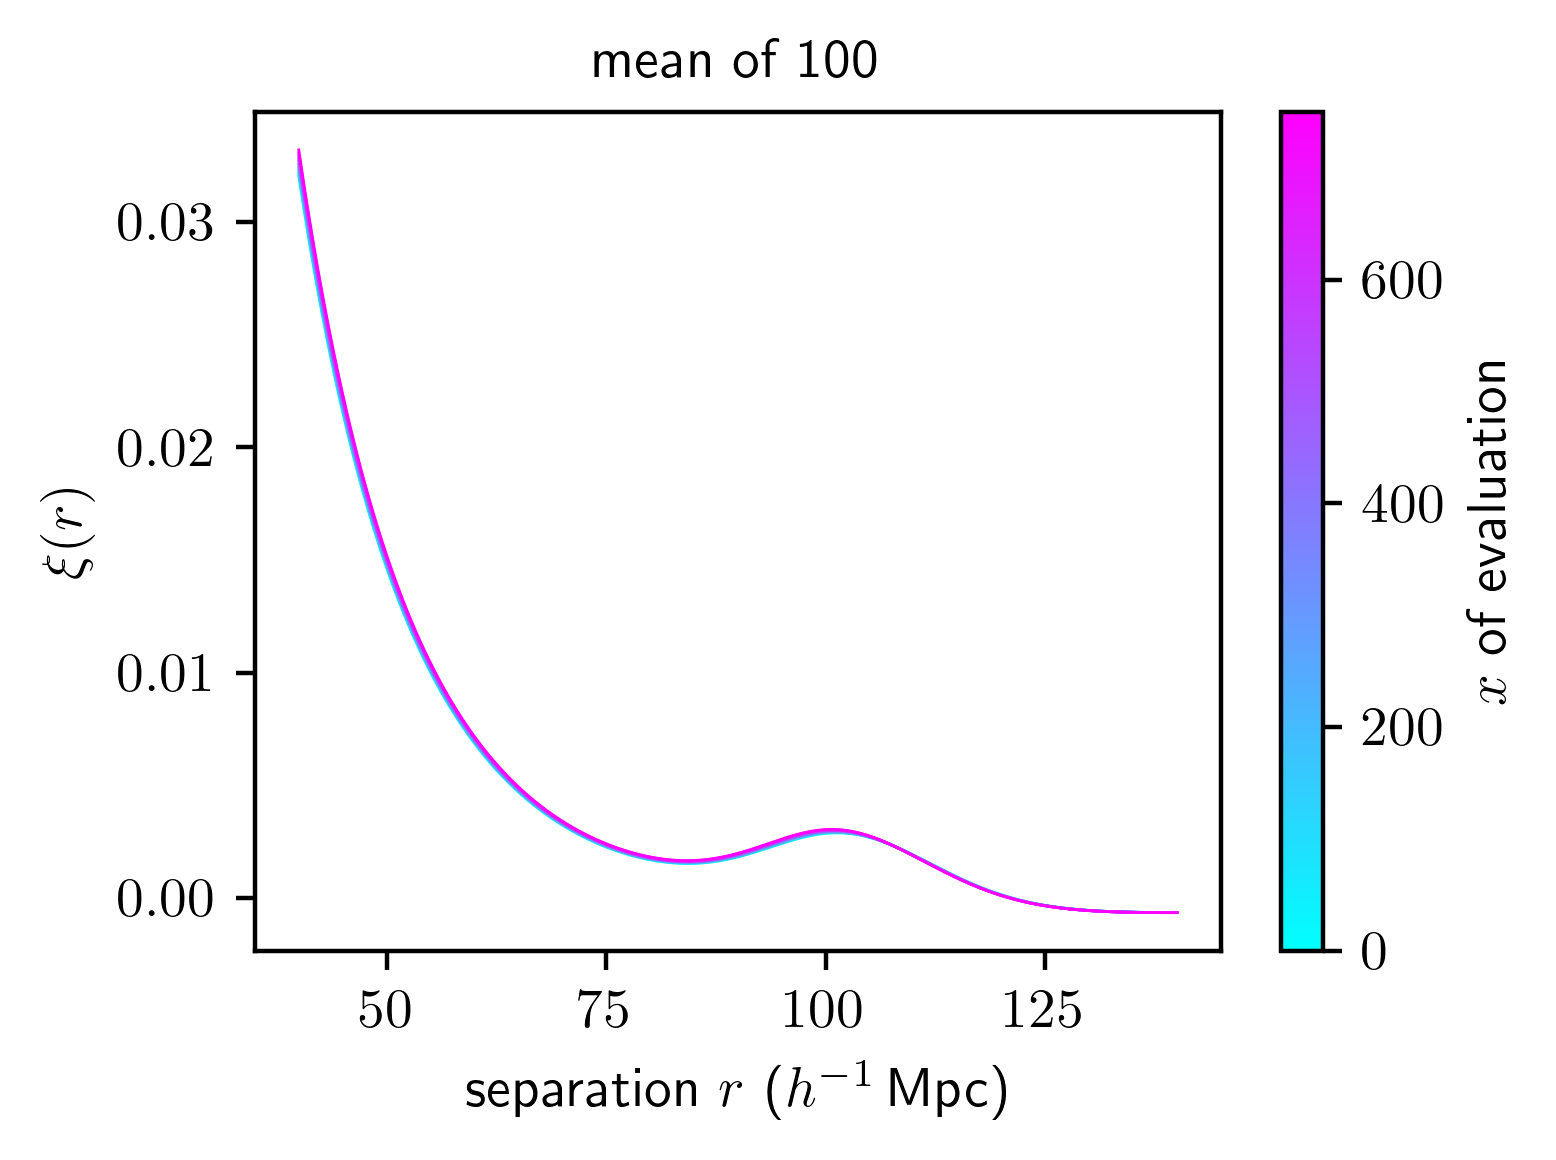

In [30]:
proj = 'gradient'
binwidth = 10 #dummy
cf_tag = f"_{proj}_bao_rand3x"
realizations = range(100)

cat_tag = '_L750_n5e-5_z057_patchy'
qq_tag = '_qqnum'

result_dir = f'../results/results_lognormal{cat_tag}'

fig = plt.figure()
ax = plt.gca()

nlocs = 10
loc_min = 0.0
loc_max = 750.0
locs = np.linspace(loc_min, loc_max, nlocs)
locs_norm = matplotlib.colors.Normalize(vmin=loc_min, vmax=loc_max)
cmap = matplotlib.cm.get_cmap('cool')

for i, loc in enumerate(locs):
    
    weights1 = np.array([1.0, loc-loc_pivot[0], L/2.-loc_pivot[1], L/2.-loc_pivot[2]])
    weights2 = weights1 #because we just take the average of these and want to get this back
    
    xis = []
    
    for Nr in realizations:
        results_fn = f'{result_dir}/cf{cf_tag}{qq_tag}{cat_tag}_rlz{Nr}.npy'
        r, xi, amps, proj, extra_dict = np.load(results_fn, allow_pickle=True)
        r_edges_mocks = extra_dict['r_edges']
        proj_type, projfn, weight_type, loc_pivot = \
           extra_dict['proj_type'],  extra_dict['projfn'], extra_dict['weight_type'], extra_dict['loc_pivot']

        xi_loc = evaluate_xi(amps, r_fine, proj_type, rbins=r_edges_mocks, projfn=projfn, 
                         weights1=weights1, weights2=weights2, weight_type=weight_type)    
        xis.append(xi_loc)

    xi_mean = np.mean(xis, axis=0)
    plt.plot(r_fine, xi_mean, color=cmap(locs_norm(loc)), alpha=1, lw=0.5)    

sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, label=r'$x$ of evaluation')

plt.title(f"mean of {len(realizations)}")
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi(r)$')

# OK let's find the gradients!


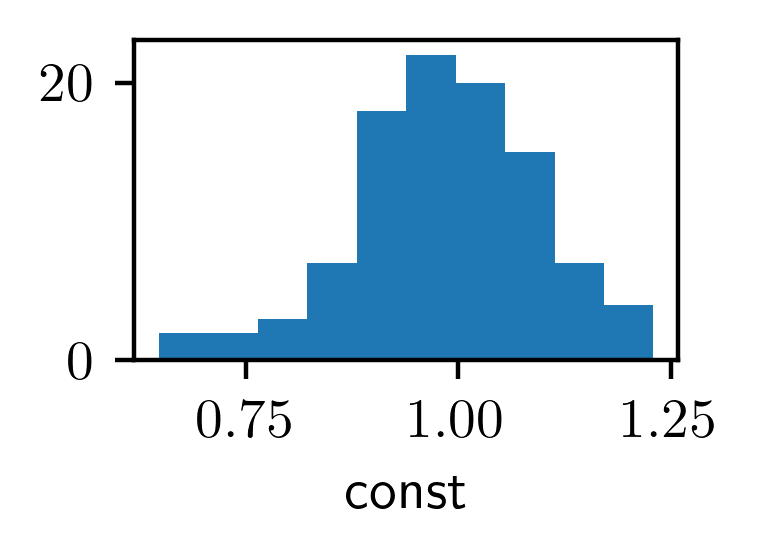

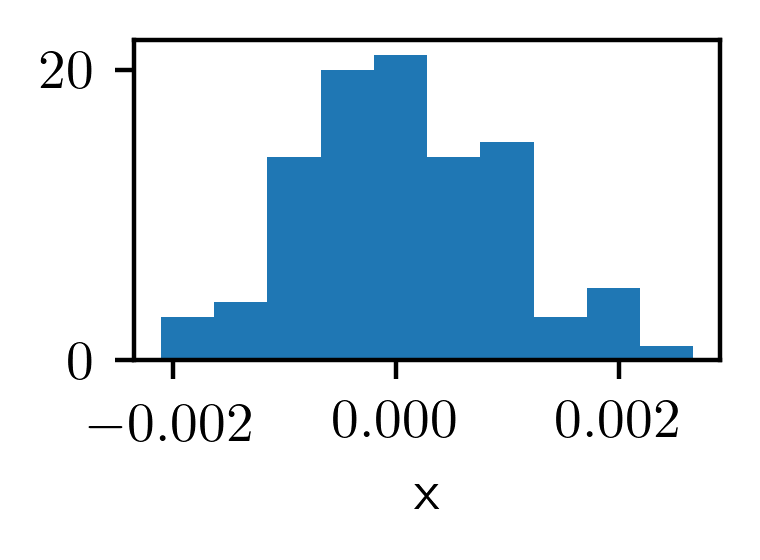

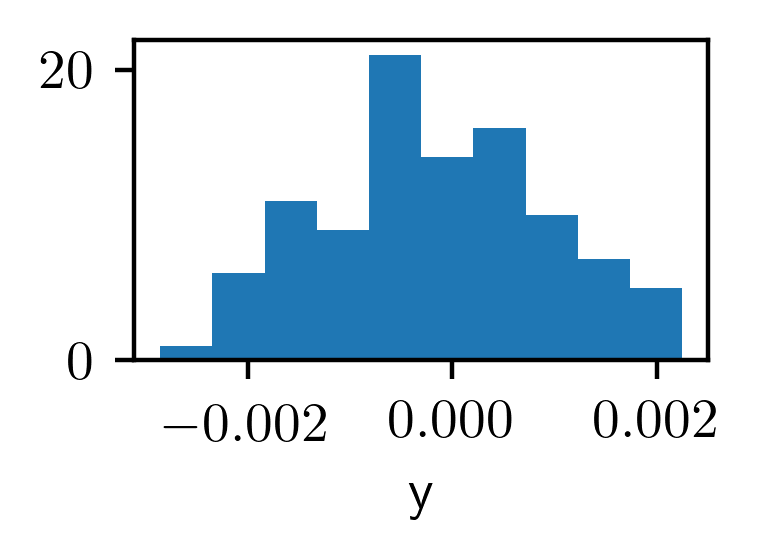

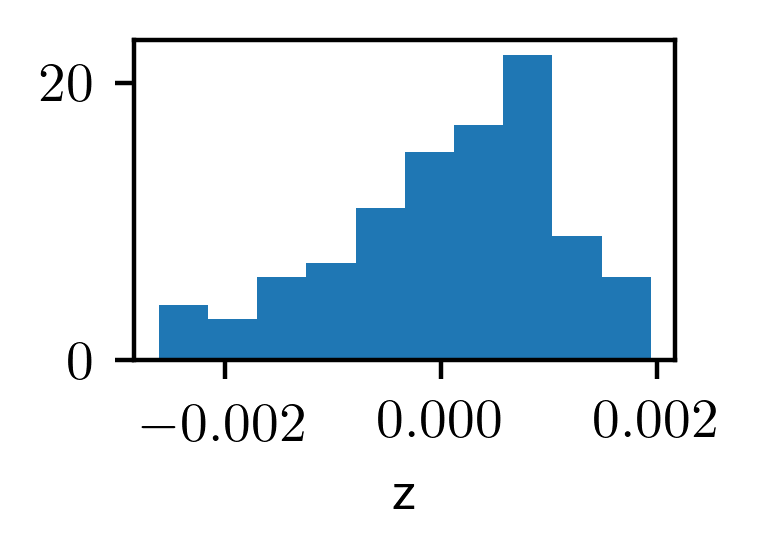

In [36]:
proj = 'gradient'
binwidth = 10 #dummy
cf_tag = f"_{proj}_bao_rand3x"
realizations = range(100)

cat_tag = '_L750_n5e-5_z057_patchy'
qq_tag = '_qqnum'

result_dir = f'../results/results_lognormal{cat_tag}'

amps_all = []
for Nr in realizations:
    results_fn = f'{result_dir}/cf{cf_tag}{qq_tag}{cat_tag}_rlz{Nr}.npy'
    r, xi, amps, proj, extra_dict = np.load(results_fn, allow_pickle=True)
    r_edges_mocks = extra_dict['r_edges']
    proj_type, projfn, weight_type, loc_pivot = \
       extra_dict['proj_type'],  extra_dict['projfn'], extra_dict['weight_type'], extra_dict['loc_pivot']

    amps_all.append(amps) 

amps_all = np.array(amps_all)
amp_labels = ['const', 'x', 'y', 'z']
for i in range(amps_all.shape[1]):
    
    plt.figure(figsize=(2,1.5))
    plt.hist(amps_all[:,i])
    plt.xlabel(amp_labels[i])

### Look at gradient along maximum direction:

[-1.18013602e-03 -4.00919107e-05  1.29068834e-03]
[-0.67461629 -0.02291825  0.73781273]
0.0017493440962091976
[375. 375. 375.]
[122.01889211 366.40565511 651.67977209]


Text(0, 0.5, '$\\xi(r)$')

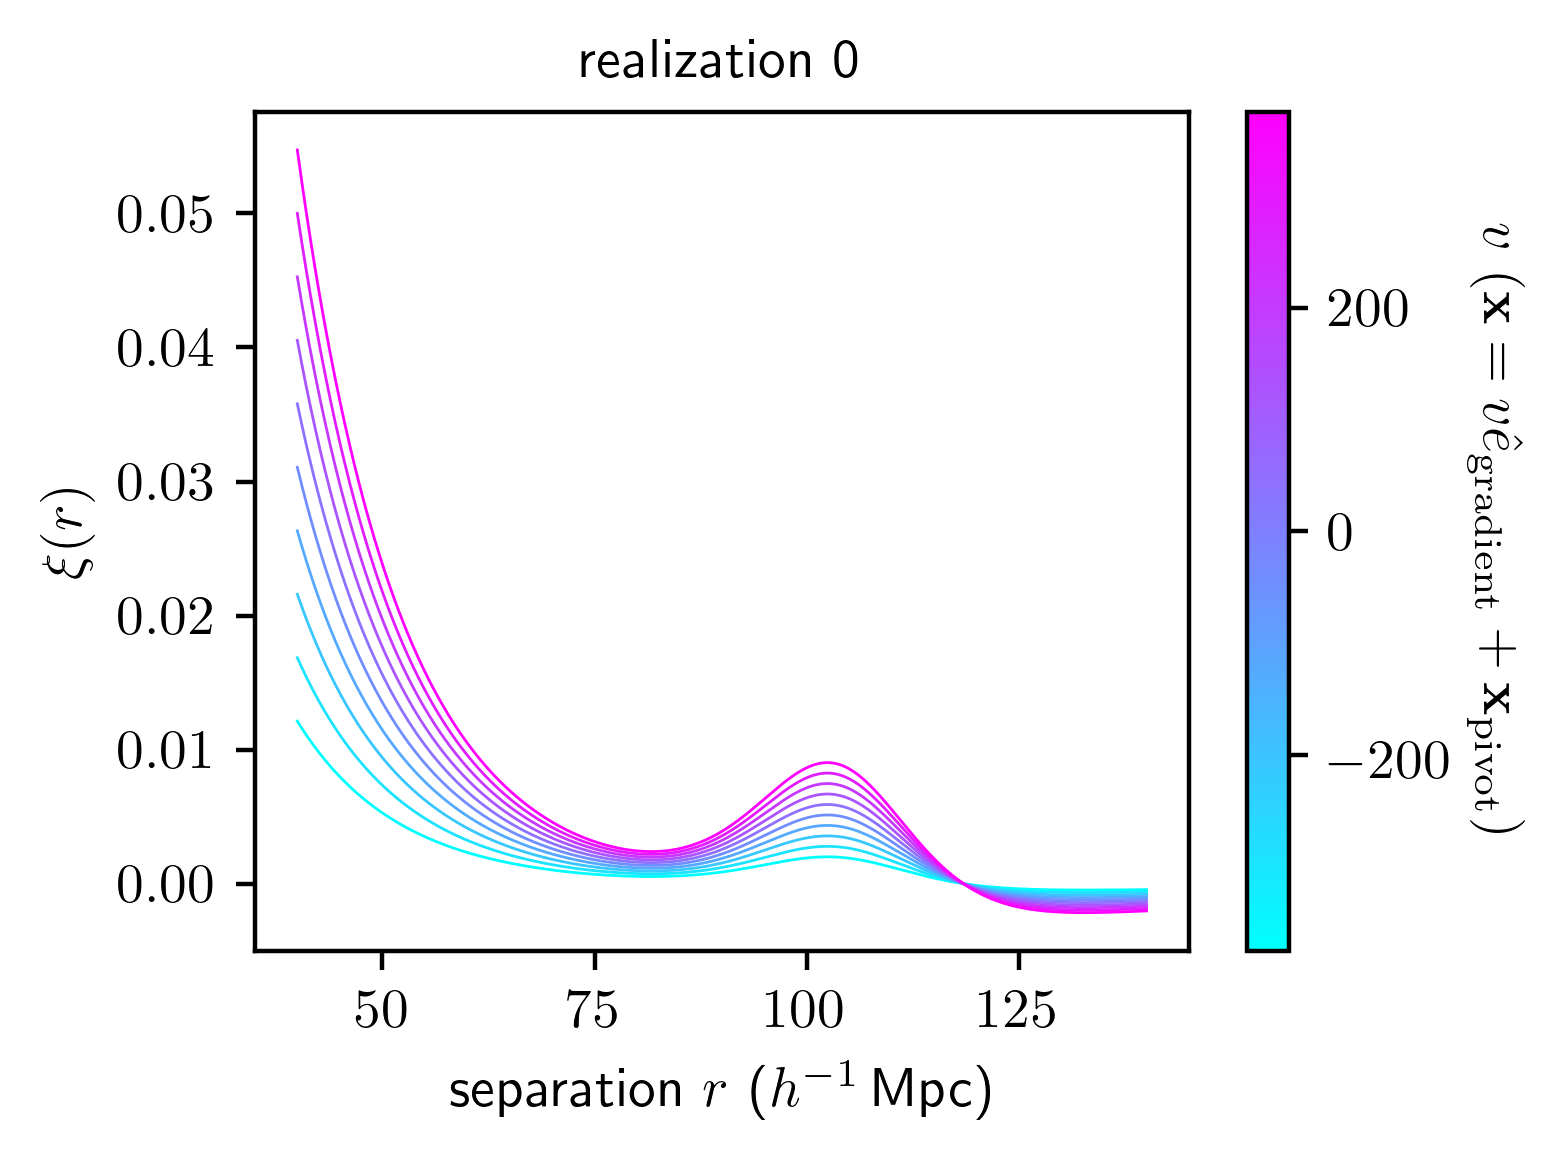

In [153]:
proj = 'gradient'
binwidth = 10 #dummy
cf_tag = f"_{proj}_bao_rand3x"
Nr = 0

L = 750
cat_tag = f'_L{L}_n2e-4_z057_patchy'
qq_tag = '_qqnum'

result_dir = f'../results/results_lognormal{cat_tag}'
results_fn = f'{result_dir}/cf{cf_tag}{qq_tag}{cat_tag}_rlz{Nr}.npy'
r, xi, amps, proj, extra_dict = np.load(results_fn, allow_pickle=True)

v_grad = amps[1:]
v_grad_hat = v_grad/np.linalg.norm(v_grad)
print(v_grad)
print(v_grad_hat)
print(np.linalg.norm(v_grad))

proj_type, projfn, weight_type, loc_pivot = \
           extra_dict['proj_type'],  extra_dict['projfn'], extra_dict['weight_type'], extra_dict['loc_pivot']
loc_pivot = np.array(loc_pivot)

print(loc_pivot)
fig = plt.figure()
ax = plt.gca()

v_min = -L/2.
v_max = L/2.
vs_norm = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
cmap = matplotlib.cm.get_cmap('cool')
nvs = 10
vs = np.linspace(v_min, v_max, nvs)

for i, v in enumerate(vs):
    loc = loc_pivot + v*v_grad_hat
    if i==len(vs)-1:
        print(loc)
    weights1 = np.array(np.concatenate(([1.0], loc-loc_pivot)))
    weights2 = weights1 #because we just take the average of these and want to get this back
    xi_loc = evaluate_xi(amps, r_fine, proj_type, projfn=projfn, 
                     weights1=weights1, weights2=weights2, weight_type=weight_type)    
    
    p = plt.plot(r_fine, xi_loc, color=cmap(vs_norm(v)), lw=0.5)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=vs_norm)
cbar = plt.colorbar(sm)
cbar.set_label(r'$v \,\, (\mathbf{x} = v\hat{e}_\mathrm{gradient} + \mathbf{x}_\mathrm{pivot})$', rotation=270, labelpad=12)

plt.title(f"realization {Nr}")
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi(r)$')

### Look at dependence along vector perpendicular to gradient

In [73]:
# from https://codereview.stackexchange.com/questions/43928/algorithm-to-get-an-arbitrary-perpendicular-vector
def perpendicular_vector(v):
    if v[1] == 0 and v[2] == 0:
        if v[0] == 0:
            raise ValueError('zero vector')
        else:
            v_perp = np.cross(v, [0, 1, 0])
    else:
        v_perp = np.cross(v, [1, 0, 0])
    return v_perp/np.linalg.norm(v_perp)

[375. 375. 375.]


Text(0, 0.5, '$\\xi(r)$')

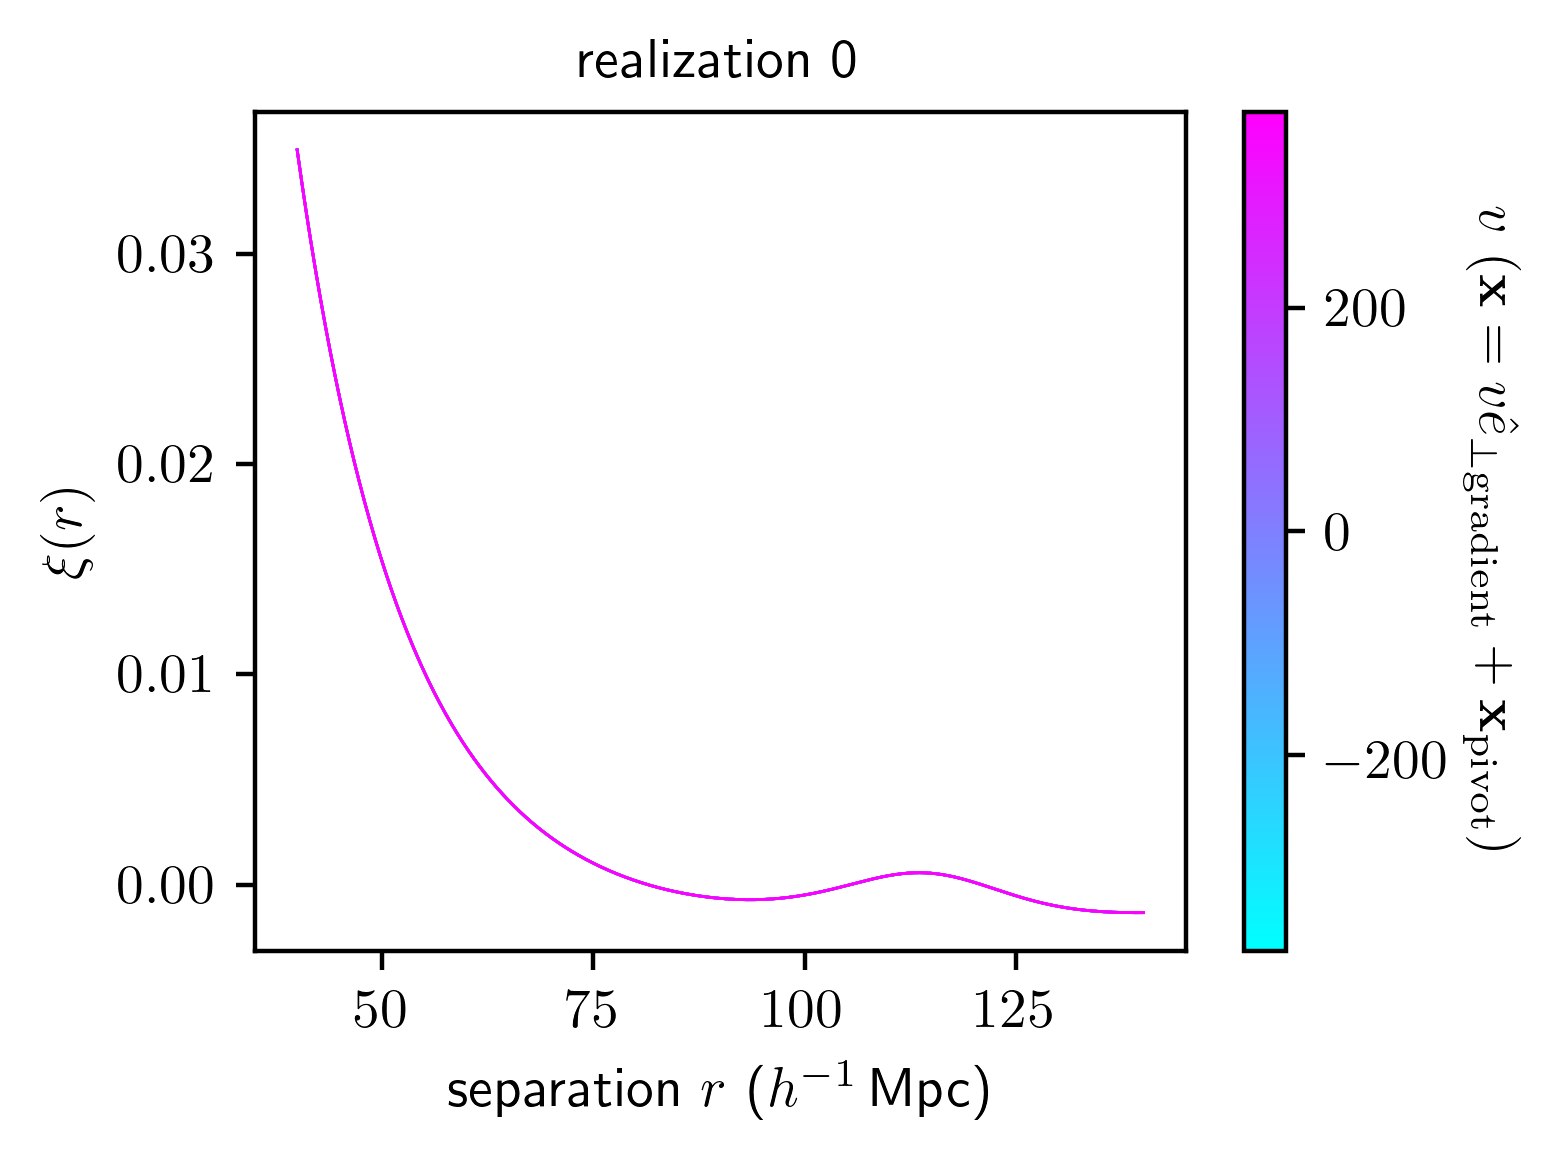

In [151]:
proj = 'gradient'
binwidth = 10 #dummy
cf_tag = f"_{proj}_bao_rand3x"
Nr = 28

L = 750
cat_tag = f'_L{L}_n2e-4_z057_patchy'
qq_tag = '_qqnum'

result_dir = f'../results/results_lognormal{cat_tag}'
results_fn = f'{result_dir}/cf{cf_tag}{qq_tag}{cat_tag}_rlz{Nr}.npy'
r, xi, amps, proj, extra_dict = np.load(results_fn, allow_pickle=True)

v_grad = amps[1:]
v_grad_hat = v_grad/np.linalg.norm(v_grad)
v_perp_hat = perpendicular_vector(v_grad_hat)

proj_type, projfn, weight_type, loc_pivot = \
           extra_dict['proj_type'],  extra_dict['projfn'], extra_dict['weight_type'], extra_dict['loc_pivot']
loc_pivot = np.array(loc_pivot)

print(loc_pivot)
fig = plt.figure()
ax = plt.gca()

v_min = -L/2.
v_max = L/2.
vs_norm = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
cmap = matplotlib.cm.get_cmap('cool')
nvs = 10
vs = np.linspace(v_min, v_max, nvs)

for i, v in enumerate(vs):
    loc = loc_pivot + v*v_perp_hat
    weights1 = np.array(np.concatenate(([1.0], loc-loc_pivot)))
    weights2 = weights1 #because we just take the average of these and want to get this back
    xi_loc = evaluate_xi(amps, r_fine, proj_type, projfn=projfn, 
                     weights1=weights1, weights2=weights2, weight_type=weight_type)    
    
    p = plt.plot(r_fine, xi_loc, color=cmap(vs_norm(v)), lw=0.5)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=vs_norm)
cbar = plt.colorbar(sm)
cbar.set_label(r'$v \,\, (\mathbf{x} = v\hat{e}_{\perp \mathrm{gradient}} + \mathbf{x}_\mathrm{pivot})$', rotation=270, labelpad=12)

plt.title("realization 0")
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi(r)$')

[375. 375. 375.]


Text(0, 0.5, '$\\xi(r)$')

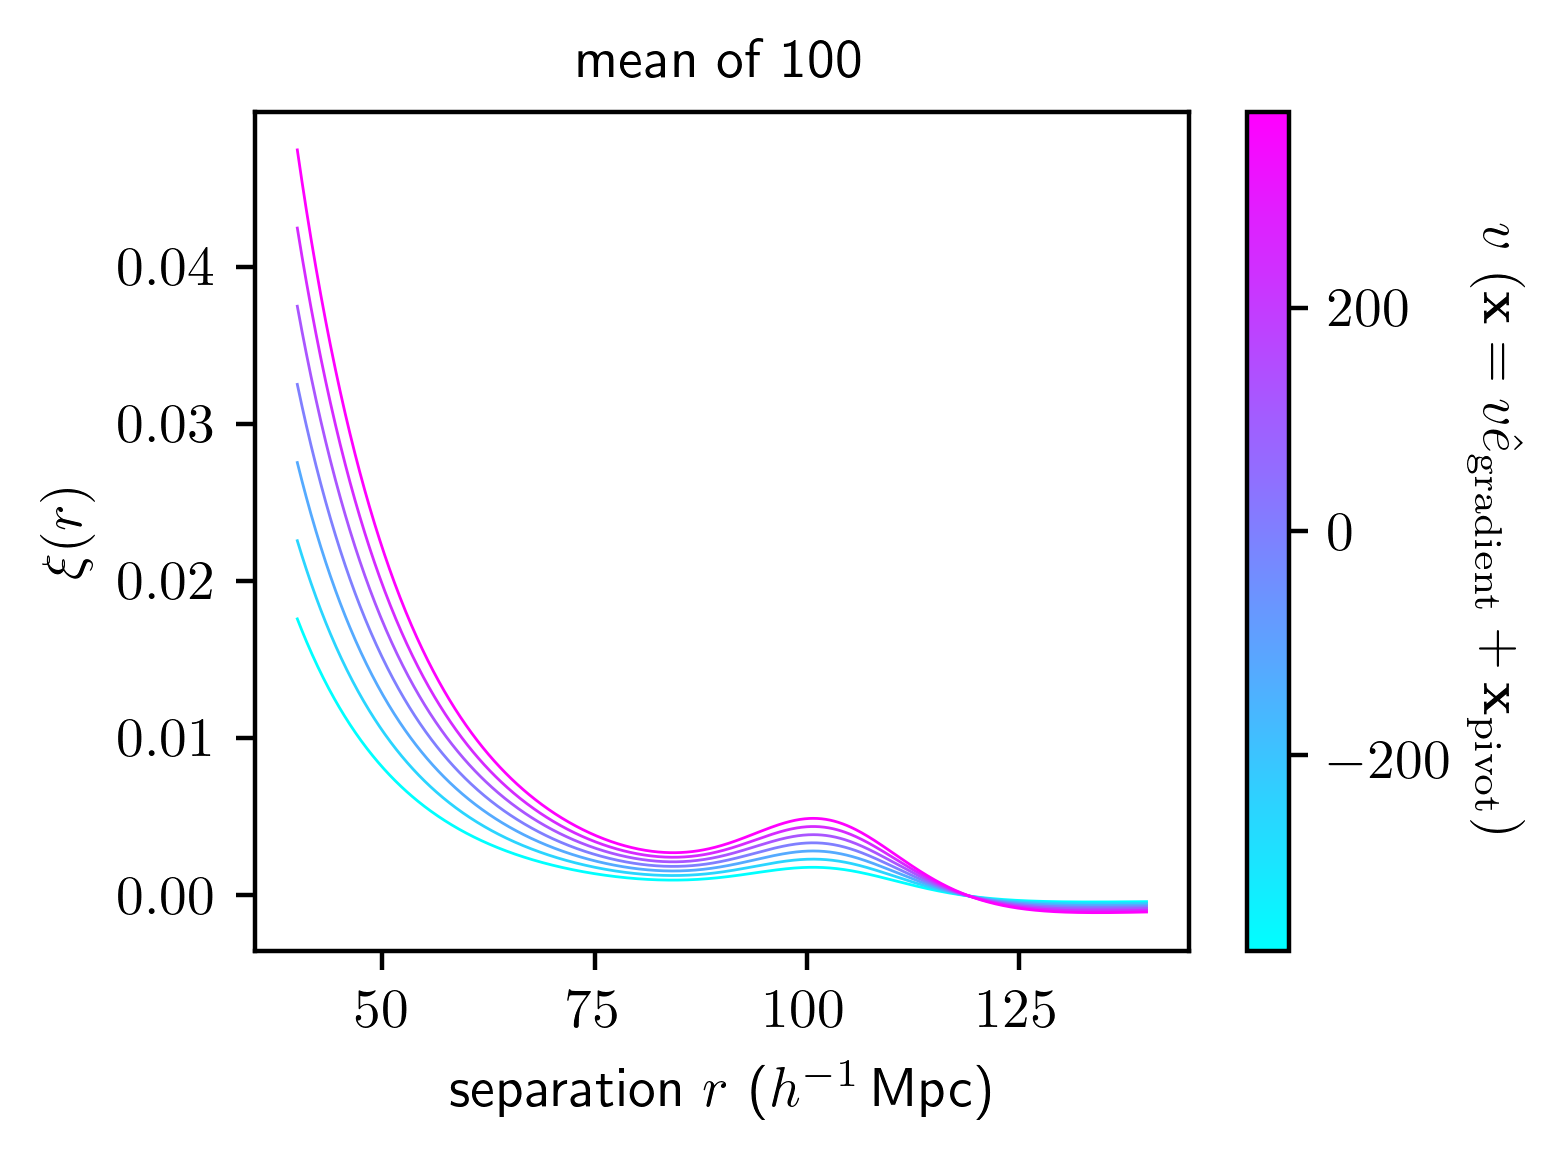

In [154]:
proj = 'gradient'
binwidth = 10 #dummy
cf_tag = f"_{proj}_bao_rand3x"
realizations = range(100)
#realizations = [9]

L = 750
cat_tag = f'_L{L}_n2e-4_z057_patchy'
qq_tag = '_qqnum'

result_dir = f'../results/results_lognormal{cat_tag}'

print(loc_pivot)
fig = plt.figure()
ax = plt.gca()

v_min = -L/2.
v_max = L/2.
vs_norm = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
cmap = matplotlib.cm.get_cmap('cool')
nvs = 7
vs = np.linspace(v_min, v_max, nvs)

for i, v in enumerate(vs):
    
    xis = []
    for Nr in realizations:
        
        results_fn = f'{result_dir}/cf{cf_tag}{qq_tag}{cat_tag}_rlz{Nr}.npy'
        r, xi, amps, proj, extra_dict = np.load(results_fn, allow_pickle=True)
        v_grad = amps[1:]
        v_grad_hat = v_grad/np.linalg.norm(v_grad)
        proj_type, projfn, weight_type, loc_pivot = \
                   extra_dict['proj_type'],  extra_dict['projfn'], extra_dict['weight_type'], extra_dict['loc_pivot']
        loc_pivot = np.array(loc_pivot)

        loc = loc_pivot + v*v_grad_hat
        weights1 = np.array(np.concatenate(([1.0], loc-loc_pivot)))
        weights2 = weights1 #because we just take the average of these and want to get this back
        xi_loc = evaluate_xi(amps, r_fine, proj_type, projfn=projfn, 
                         weights1=weights1, weights2=weights2, weight_type=weight_type)    

        xis.append(xi_loc)

    xi_mean = np.mean(xis, axis=0)
    plt.plot(r_fine, xi_mean, color=cmap(vs_norm(v)), alpha=1, lw=0.5)   
    #plt.plot(r_fine, xi_loc, color=cmap(vs_norm(v)))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=vs_norm)
cbar = plt.colorbar(sm)
cbar.set_label(r'$v \,\, (\mathbf{x} = v\hat{e}_\mathrm{gradient} + \mathbf{x}_\mathrm{pivot})$', 
               rotation=270, labelpad=12)

plt.title(f"mean of {len(realizations)}")
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi(r)$')

Text(0, 0.5, '$\\xi(r)$')

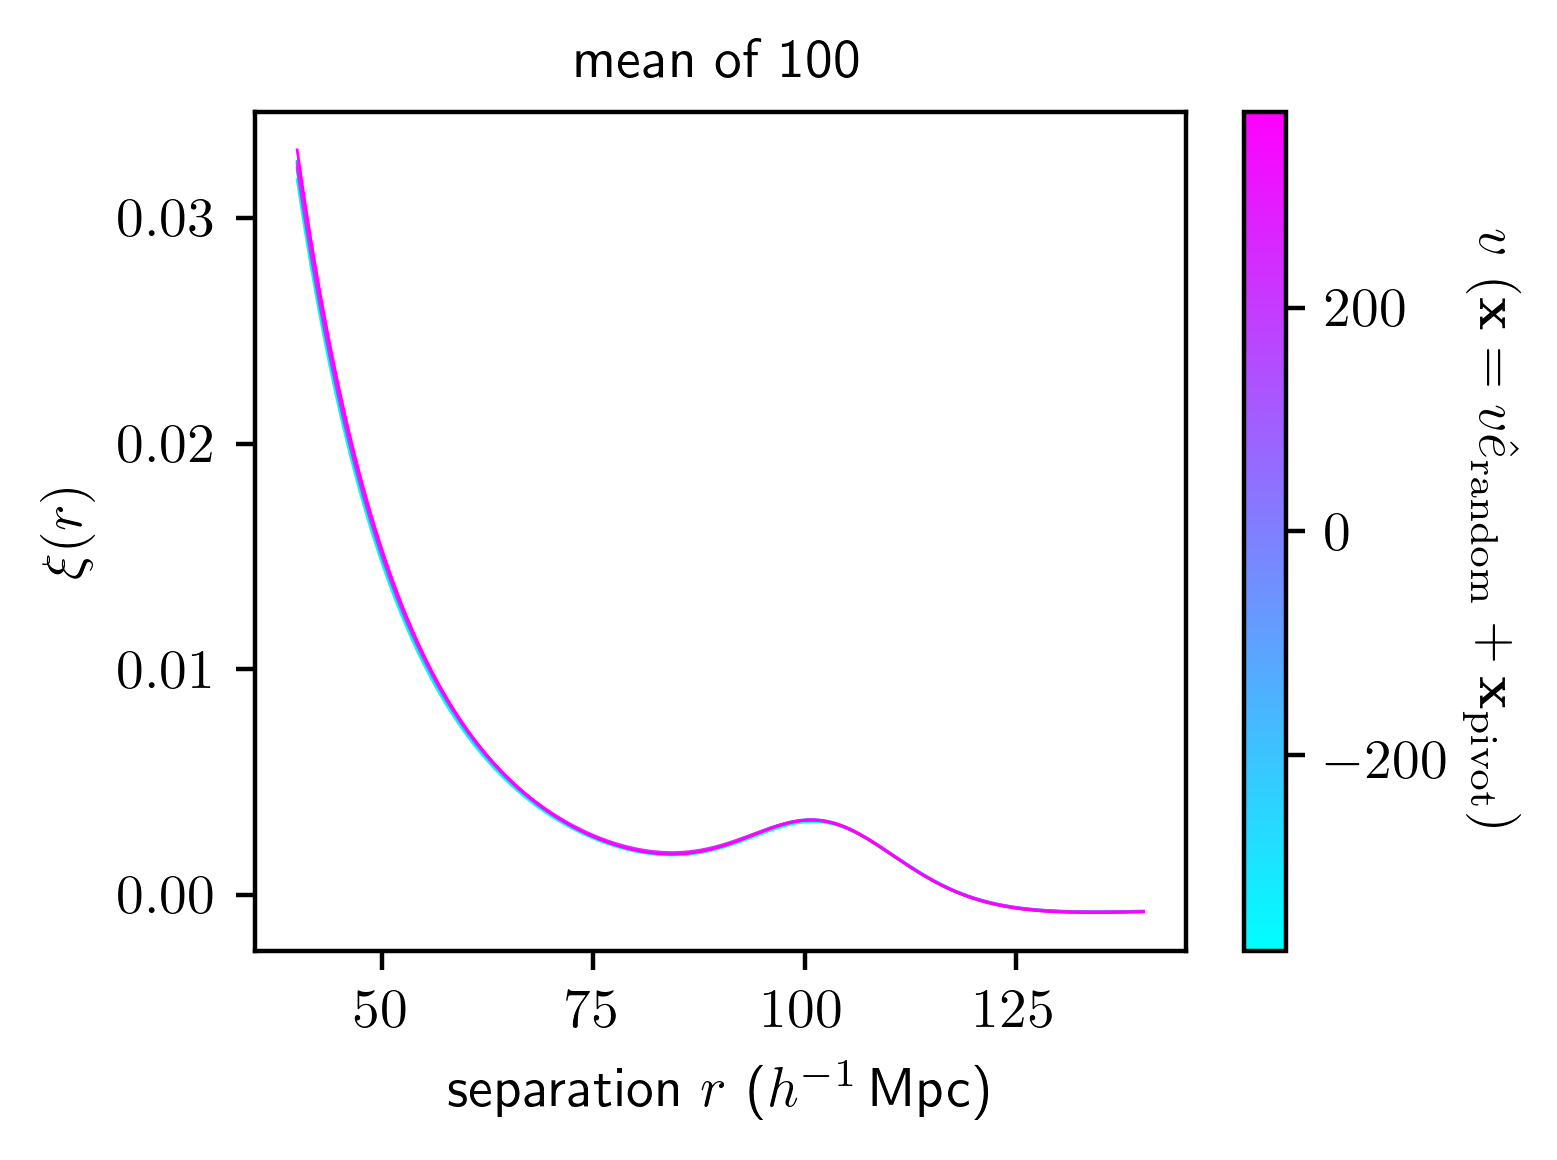

In [11]:
proj = 'gradient'
binwidth = 10 #dummy
cf_tag = f"_{proj}_bao_rand3x"
realizations = range(100)
#realizations = [9]

L = 750
cat_tag = f'_L{L}_n2e-4_z057_patchy'
qq_tag = '_qqnum'

result_dir = f'../results/results_lognormal{cat_tag}'

fig = plt.figure()
ax = plt.gca()

v_min = -L/2.
v_max = L/2.
vs_norm = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
cmap = matplotlib.cm.get_cmap('cool')
nvs = 7
vs = np.linspace(v_min, v_max, nvs)

for i, v in enumerate(vs):
    
    xis = []
    for Nr in realizations:
        
        results_fn = f'{result_dir}/cf{cf_tag}{qq_tag}{cat_tag}_rlz{Nr}.npy'
        r, xi, amps, proj, extra_dict = np.load(results_fn, allow_pickle=True)
        v_rand = np.random.normal(size=3)
        v_rand_hat = v_rand/np.linalg.norm(v_rand)
        proj_type, projfn, weight_type, loc_pivot = \
                   extra_dict['proj_type'],  extra_dict['projfn'], extra_dict['weight_type'], extra_dict['loc_pivot']
        loc_pivot = np.array(loc_pivot)

        loc = loc_pivot + v*v_rand_hat
        weights1 = np.array(np.concatenate(([1.0], loc-loc_pivot)))
        weights2 = weights1 #because we just take the average of these and want to get this back
        xi_loc = evaluate_xi(amps, r_fine, proj_type, projfn=projfn, 
                         weights1=weights1, weights2=weights2, weight_type=weight_type)    

        xis.append(xi_loc)

    xi_mean = np.mean(xis, axis=0)
    plt.plot(r_fine, xi_mean, color=cmap(vs_norm(v)), alpha=1, lw=0.5)   
    #plt.plot(r_fine, xi_loc, color=cmap(vs_norm(v)))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=vs_norm)
cbar = plt.colorbar(sm)
cbar.set_label(r'$v \,\, (\mathbf{x} = v\hat{e}_\mathrm{random} + \mathbf{x}_\mathrm{pivot})$', 
               rotation=270, labelpad=12)

plt.title(f"mean of {len(realizations)}")
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi(r)$')

[375. 375. 375.]


Text(0, 0.5, '$\\xi(r)$')

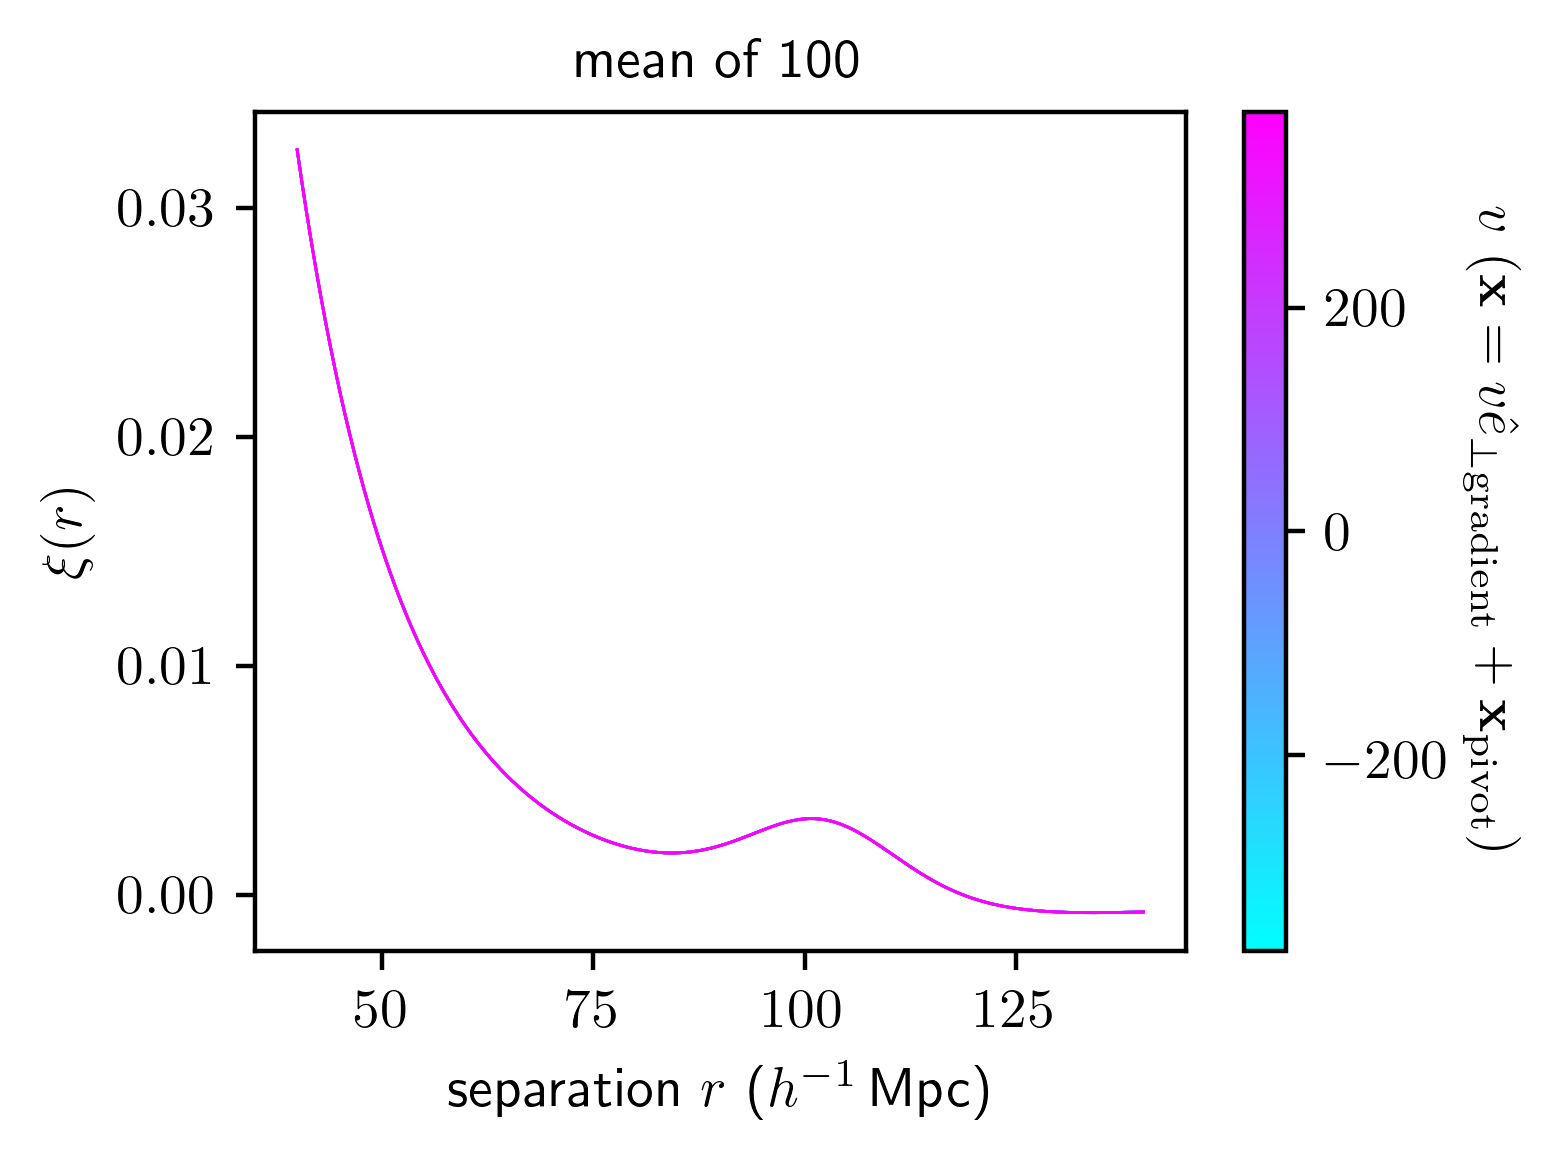

In [155]:
proj = 'gradient'
binwidth = 10 #dummy
cf_tag = f"_{proj}_bao_rand3x"
realizations = range(100)

L = 750
cat_tag = f'_L{L}_n2e-4_z057_patchy'
qq_tag = '_qqnum'

result_dir = f'../results/results_lognormal{cat_tag}'

print(loc_pivot)
fig = plt.figure()
ax = plt.gca()

v_min = -L/2.
v_max = L/2.
vs_norm = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
cmap = matplotlib.cm.get_cmap('cool')
nvs = 10
vs = np.linspace(v_min, v_max, nvs)

for i, v in enumerate(vs):
    
    xis = []
    for Nr in realizations:
        
        results_fn = f'{result_dir}/cf{cf_tag}{qq_tag}{cat_tag}_rlz{Nr}.npy'
        r, xi, amps, proj, extra_dict = np.load(results_fn, allow_pickle=True)
        v_grad = amps[1:]
        v_grad_hat = v_grad/np.linalg.norm(v_grad)
        v_perp_hat = perpendicular_vector(v_grad_hat)
        proj_type, projfn, weight_type, loc_pivot = \
                   extra_dict['proj_type'],  extra_dict['projfn'], extra_dict['weight_type'], extra_dict['loc_pivot']
        loc_pivot = np.array(loc_pivot)

        loc = loc_pivot + v*v_perp_hat
        weights1 = np.array(np.concatenate(([1.0], loc-loc_pivot)))
        weights2 = weights1 #because we just take the average of these and want to get this back
        xi_loc = evaluate_xi(amps, r_fine, proj_type, projfn=projfn, 
                         weights1=weights1, weights2=weights2, weight_type=weight_type)    

        xis.append(xi_loc)

    xi_mean = np.mean(xis, axis=0)
    plt.plot(r_fine, xi_mean, color=cmap(vs_norm(v)), alpha=1, lw=0.5)   

sm = plt.cm.ScalarMappable(cmap=cmap, norm=vs_norm)
cbar = plt.colorbar(sm)
cbar.set_label(r'$v \,\, (\mathbf{x} = v\hat{e}_{\perp \mathrm{gradient}} + \mathbf{x}_\mathrm{pivot})$', rotation=270, labelpad=12)



plt.title(f"mean of {len(realizations)}")
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'$\xi(r)$')

In [65]:
############

## we've got some visuals, let's calculate how strong these gradients are

Mean: [-1.75438619e-05 -1.25865215e-04  1.57641288e-04]


Text(0.5, 0, '$||v_\\mathrm{grad}||$')

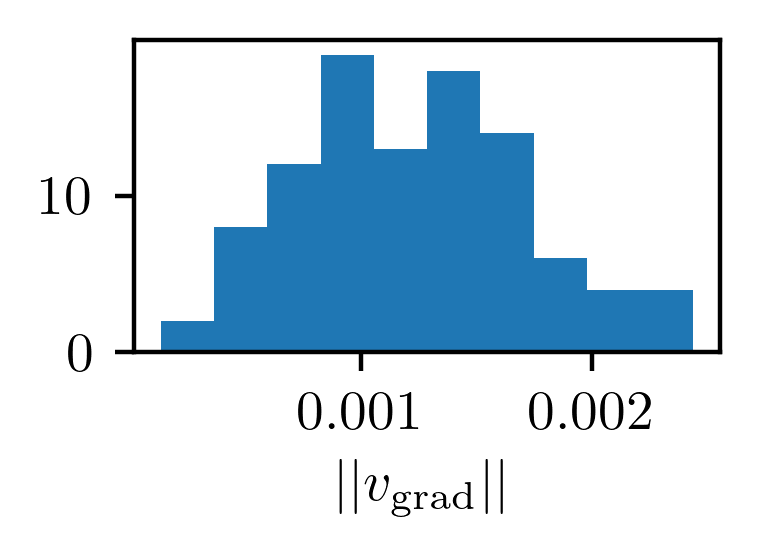

In [84]:
proj = 'gradient'
binwidth = 10 #dummy
cf_tag = f"_{proj}_bao_rand3x"
realizations = range(100)

cat_tag = '_L750_n2e-4_z057_patchy'
qq_tag = '_qqnum'

result_dir = f'../results/results_lognormal{cat_tag}'

amps_all = []
for Nr in realizations:
    results_fn = f'{result_dir}/cf{cf_tag}{qq_tag}{cat_tag}_rlz{Nr}.npy'
    r, xi, amps, proj, extra_dict = np.load(results_fn, allow_pickle=True)
    r_edges_mocks = extra_dict['r_edges']
    proj_type, projfn, weight_type, loc_pivot = \
       extra_dict['proj_type'],  extra_dict['projfn'], extra_dict['weight_type'], extra_dict['loc_pivot']
    amps_all.append(amps) 

amps_all = np.array(amps_all)
print("Mean:", np.mean(amps_all[:,1:], axis=0))
    
grad_mags = []
for i in range(amps_all.shape[0]):
    v_grad = amps_all[i,1:]
    grad_mag = np.linalg.norm(v_grad)
    grad_mags.append(grad_mag)

plt.figure(figsize=(2,1.5))
plt.hist(grad_mags)
plt.xlabel(r"$||v_\mathrm{grad}||$")

(-0.002439577197770207, 0.002439577197770207)

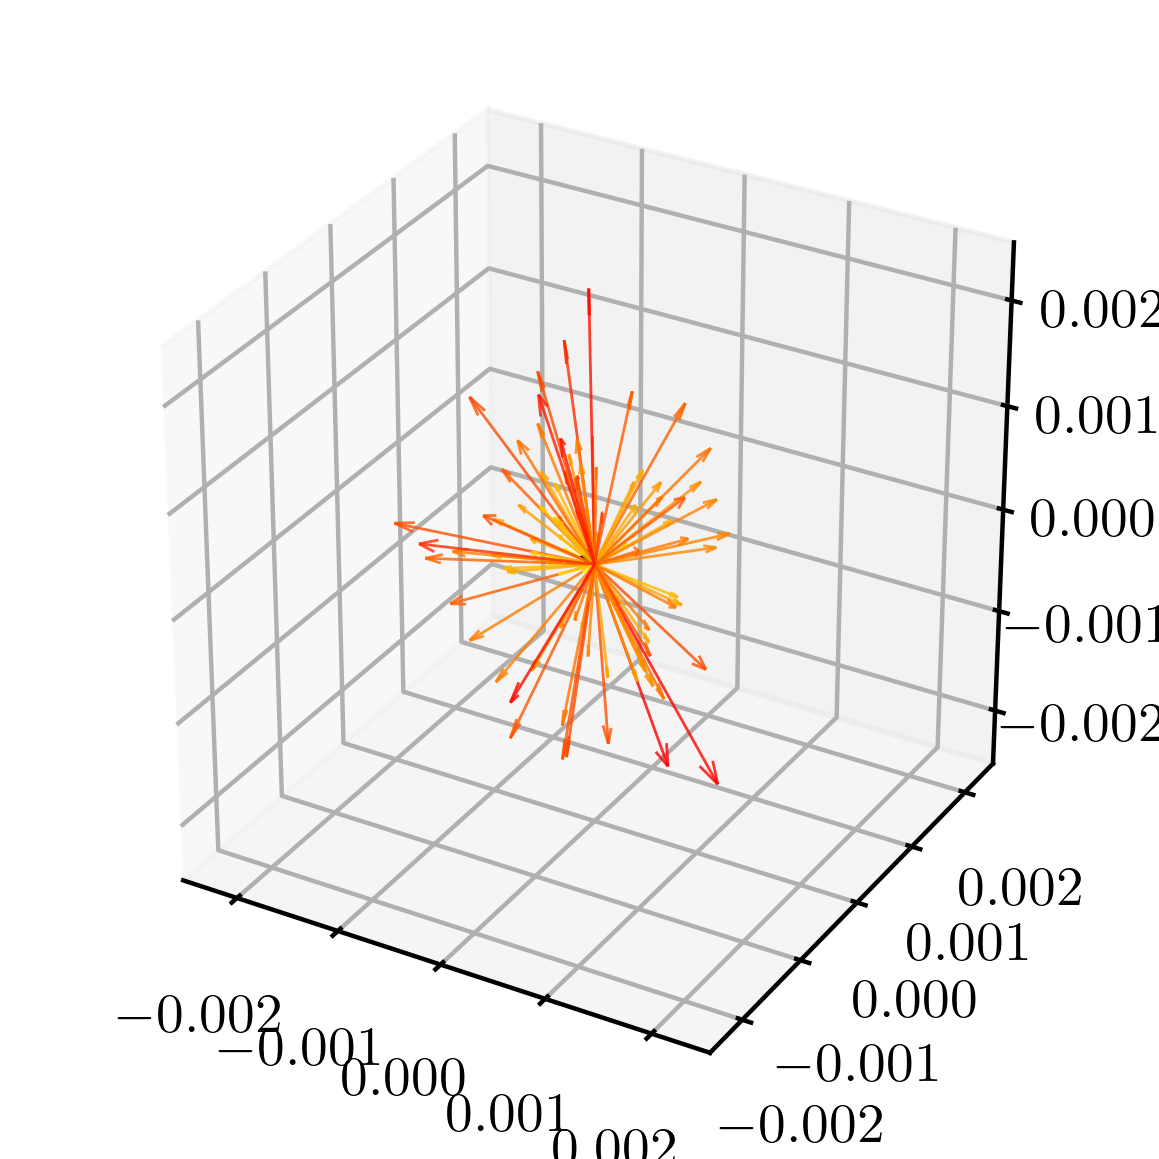

In [103]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(3,3))
ax = fig.gca(projection='3d')

#
v_min = min(grad_mags)
v_max = max(grad_mags)
v_norm = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
cmap = matplotlib.cm.get_cmap('autumn_r')

#for i in range(10):
for i in range(amps_all.shape[0]):
    v_zero = np.zeros(3)
    v_grad = amps_all[i,1:]
    #ax.plot((v_zero[0], v_grad[0]), (v_zero[1], v_grad[1]), (v_zero[2], v_grad[2]), color=cmap(v_norm(grad_mags[i])))
    plt.quiver(v_zero[0], v_zero[1], v_zero[2], v_grad[0], v_grad[1], v_grad[2], 
              color=cmap(v_norm(grad_mags[i])), arrow_length_ratio=0.1, lw=0.5, alpha=0.8)
    
v_mean = np.mean(amps_all[:,1:], axis=0)    
plt.quiver(v_zero[0], v_zero[1], v_zero[2], v_mean[0], v_mean[1], v_mean[2], 
              color='k', arrow_length_ratio=0.1, lw=2)

mag_max = max(grad_mags)
ax.set_xlim(-mag_max, mag_max)
ax.set_ylim(-mag_max, mag_max)
ax.set_zlim(-mag_max, mag_max)

We can't even see the mean vector it's so small! Aka avg is basically 0.